# <b> Calculating Seasonal Runoff (Updated 4-2-23)

In [505]:
# Import packages
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns

## <b> <i> Functions

In [2]:
# Function: load the dataset
def open_series(fpath_stem, which_date, which_gcm, which_rcp):
    this_fpath = fpath_stem+'{}-gcm_data_{}_{}_compiled_output.nc'.format(which_date, which_gcm, which_rcp)
    this_ds = xr.open_dataset(this_fpath)
    return this_ds

In [3]:
# Function: calculate runoff
def calc_seasonal(this_ds):
    melt1 = this_ds.melt_on_glacier_monthly
    melt2 = this_ds.melt_off_glacier_monthly
    melt3 = this_ds.liq_prcp_off_glacier_monthly
    melt4 = this_ds.liq_prcp_on_glacier_monthly
    
    this_sum = melt1.sum(dim='rgi_id').dropna(dim='time') + melt2.sum(dim='rgi_id').dropna(dim='time') + melt3.sum(dim='rgi_id').dropna(dim='time') + melt4.sum(dim='rgi_id').dropna(dim='time')
    nonzero_sum = this_sum.where(this_sum!=0, drop=True)
    nonzero_sum *= 1e-9

    return nonzero_sum

In [4]:
# Function: select a year and take the mean runoff of all gcms for this year
def season_sliced(keys, dictionary, time):
    new_df = pd.DataFrame()
    for k in keys:
        new = dictionary[k]
        new = new[time]
        new = pd.DataFrame(new)
        new_df[k] = new
    new_df['mean'] = new_df.transpose().mean()
    return new_df

In [5]:
# Make a function that calculates a given runoff value, which I can visualize later
def rtype_calc_monthly(keys, dictionary, runoff):
    dataframe = pd.DataFrame()
    for k in keys:
        rtype_gcm = dictionary[k]
        rtype = rtype_gcm[runoff]
        rtype = pd.DataFrame(rtype)
        dataframe[k] = rtype
    dataframe['mean'] = dataframe.transpose().mean()
    return dataframe

In [6]:
# Make a function that calculates a given runoff value, which I can visualize later
def rtype_calc_monthly_2vars(keys, dictionary, runoff1, runoff2):
    dataframe = pd.DataFrame()
    for k in keys:
        rtype_gcm = dictionary[k]
        rtype1 = rtype_gcm[runoff1]
        rtype2 = rtype_gcm[runoff2]
        rsum = rtype1 + rtype2
        rtype_sum = pd.DataFrame(rsum)
        dataframe[k] = rtype_sum
    dataframe['mean'] = dataframe.transpose().mean()
    return dataframe

## <b> <i> Calculations

In [7]:
# Define variables that will be used for each test
base = '~/Documents/Molly-thesis/Data/'

gcm_list = ['CCSM4', 'CNRM-CM5', 'CSIRO-Mk3-6-0', 'CanESM2', 'GFDL-CM3', 'GFDL-ESM2G', 'GISS-E2-R', 'IPSL-CM5A-LR', 'MPI-ESM-LR', 'NorESM1-M']

date_list = ['2023-01-12', '2023-01-23', '2023-01-17', '2023-01-23', '2023-01-23', '2023-01-23', '2023-01-23', '2023-01-25', '2023-01-25', '2023-01-25']

rcp_list = ['rcp26', 'rcp45', 'rcp60', 'rcp85']

gcm_w60 = ['CCSM4', 'CSIRO-Mk3-6-0', 'GFDL-CM3', 'GFDL-ESM2G', 'GISS-E2-R', 'IPSL-CM5A-LR', 'NorESM1-M']

## Try to make a mega-dictionary with all RCPs

Create dictionary

In [8]:
all_monthly_dict = {}

Add data to dictionary

In [9]:
x=0
rcp = ['rcp26', 'rcp45', 'rcp60', 'rcp85']

for r in rcp:
    x = 0
    for gcm in gcm_list:
        if r != 'rcp60':
            rcp_value = open_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_rcp=r)
            k = '{}-{}'.format(gcm, r)
            all_monthly_dict[k] = rcp_value
        else:
            if gcm in gcm_w60:
                rcp_value = open_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_rcp=r)
                k = '{}-{}'.format(gcm, r)
                all_monthly_dict[k]=rcp_value
        x += 1

Take unrolled values to find total runoff

In [10]:
# Define keys
keys_all = all_monthly_dict.keys()

In [11]:
all_unrolled = {}
for k in keys_all:
    calculation = calc_seasonal(all_monthly_dict[k])
    z = '{}'.format(k)
    all_unrolled[z] = calculation

Roll values for plotting

In [12]:
n_roll = 6 ## how many months to roll. 6 looks nice but you can choose

dict_roll_all = {}
dict_plot_all = {}

for k in keys_all:
    season_roll = all_unrolled[k].roll(month_2d=n_roll, roll_coords=True)
    season_forplot = all_unrolled[k].roll(month_2d=n_roll, roll_coords=False)
    name = '{}'.format(k)
    dict_roll_all[name] = season_roll
    dict_plot_all[name] = season_forplot

In [13]:
dict_roll_all

{'CCSM4-rcp26': <xarray.DataArray (time: 81, month_2d: 12)>
 array([[ 4.0256324 ,  5.2154765 ,  8.265267  ,  9.66726   ,  8.0687275 ,
          7.8835373 ,  4.4750047 ,  1.4401895 ,  0.37318456,  0.3929116 ,
          1.303455  ,  1.8101832 ],
        [ 3.2039669 ,  5.452851  ,  9.929595  ,  8.25324   , 12.215373  ,
          8.254144  ,  1.3606498 ,  0.7853812 ,  0.26578063,  0.38760775,
          0.97883666,  1.681018  ],
        [ 3.887706  ,  4.308999  ,  9.635317  , 12.576422  ,  9.601589  ,
          5.3132195 ,  4.287119  ,  1.883023  ,  0.7620109 ,  0.52660227,
          0.9439405 ,  2.303439  ],
        [ 3.8022292 ,  4.61164   ,  8.247096  ,  4.494696  ,  7.7661223 ,
          4.5609326 ,  4.939513  ,  1.5148135 ,  0.29197106,  0.34543115,
          0.6118093 ,  1.3370587 ],
        [ 2.6112902 ,  4.178237  ,  7.536227  ,  9.242156  ,  8.72762   ,
          4.905159  ,  3.4274898 ,  1.0011067 ,  0.13467278,  0.5199924 ,
          0.46852356,  2.2857528 ],
        [ 3.1587431 

Take sum over rgi id

In [14]:
# Roll and sum
rtype_all = {}
n_roll = 6

for k in keys_all:
    rtype_season = all_monthly_dict[k].roll(month_2d=n_roll, roll_coords=True)
    rtype_sum = rtype_season.sum(dim='rgi_id')
    rtype_name = '{}'.format(k)
    rtype_all[rtype_name] = rtype_sum

### Calculate rcp26

In [15]:
# Make a dictionary with all data for all GCMs (this will only output one rcp!)
rcp_monthly_dict26 = {}

x=0
rcp = 'rcp26'

# Per rcp:
for gcm in gcm_list:
    if rcp != 'rcp60':
        rcp_value = open_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_rcp=rcp)
        k = '{}-{}'.format(gcm, rcp)
        rcp_monthly_dict26[k]=rcp_value
    else:
        if gcm in gcm_w60:
            rcp_value = open_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_rcp=rcp)
            k = '{}-{}'.format(gcm, rcp)
            rcp_monthly_dict26[k]=rcp_value
    x += 1

In [16]:
rcp_monthly_dict26['CCSM4-rcp26']

<xarray.Dataset>
Dimensions:                       (time: 82, rgi_id: 35, month_2d: 12)
Coordinates:
  * time                          (time) float64 2.02e+03 ... 2.101e+03
  * rgi_id                        (rgi_id) object 'RGI60-16.00495' ... 'RGI60...
    hydro_year                    (time) int64 ...
    hydro_month                   (time) int64 ...
    calendar_year                 (time) int64 ...
    calendar_month                (time) int64 ...
  * month_2d                      (month_2d) int64 1 2 3 4 5 6 7 8 9 10 11 12
    calendar_month_2d             (month_2d) int64 ...
Data variables: (12/24)
    volume                        (time, rgi_id) float32 ...
    volume_bsl                    (time, rgi_id) float32 ...
    volume_bwl                    (time, rgi_id) float32 ...
    area                          (time, rgi_id) float32 ...
    length                        (time, rgi_id) float32 ...
    calving                       (time, rgi_id) float32 ...
    ...                            ...
    liq_prcp_on_glacier_monthly   (time, month_2d, rgi_id) float32 ...
    snowfall_off_glacier_monthly  (time, month_2d, rgi_id) float32 ...
    snowfall_on_glacier_monthly   (time, month_2d, rgi_id) float32 ...
    water_level                   (rgi_id) float32 ...
    glen_a                        (rgi_id) float32 ...
    fs                            (rgi_id) float32 ...
Attributes:
    description:    OGGM model output
    oggm_version:   1.5.3
    calendar:       365-day no leap
    creation_date:  2023-01-12 16:51:46

In [17]:
# Bring in your dictionary of unrolled values to find TOTAL RUNOFF (for time slice plot)
season_unroll26 = {}
for k in rcp_monthly_dict26.keys():
    calculation = calc_seasonal(rcp_monthly_dict26[k])
    z = '{}-calc'.format(k)
    season_unroll26[z] = calculation

In [18]:
season_unroll26['CCSM4-rcp26-calc']

<xarray.DataArray (time: 81, month_2d: 12)>
array([[ 4.4750047 ,  1.4401895 ,  0.37318456,  0.3929116 ,  1.303455  ,
         1.8101832 ,  4.0256324 ,  5.2154765 ,  8.265267  ,  9.66726   ,
         8.0687275 ,  7.8835373 ],
       [ 1.3606498 ,  0.7853812 ,  0.26578063,  0.38760775,  0.97883666,
         1.681018  ,  3.2039669 ,  5.452851  ,  9.929595  ,  8.25324   ,
        12.215373  ,  8.254144  ],
       [ 4.287119  ,  1.883023  ,  0.7620109 ,  0.52660227,  0.9439405 ,
         2.303439  ,  3.887706  ,  4.308999  ,  9.635317  , 12.576422  ,
         9.601589  ,  5.3132195 ],
       [ 4.939513  ,  1.5148135 ,  0.29197106,  0.34543115,  0.6118093 ,
         1.3370587 ,  3.8022292 ,  4.61164   ,  8.247096  ,  4.494696  ,
         7.7661223 ,  4.5609326 ],
       [ 3.4274898 ,  1.0011067 ,  0.13467278,  0.5199924 ,  0.46852356,
         2.2857528 ,  2.6112902 ,  4.178237  ,  7.536227  ,  9.242156  ,
         8.72762   ,  4.905159  ],
       [ 3.3023975 ,  1.817245  ,  0.5843709 ,  0.24291047,  1.6227826 ,
         3.2233334 ,  3.1587431 ,  3.6908605 ,  8.443328  , 12.429406  ,
         9.802915  ,  6.277382  ],
       [ 2.9292815 ,  1.0479579 ,  0.5088888 ,  0.6893497 ,  0.5136057 ,
         2.3554456 ,  3.6091309 ,  3.9737828 ,  6.7912316 ,  6.728501  ,
...
         1.1145883 ,  1.5313196 ,  3.0455496 ,  4.063178  , 10.549314  ,
         7.632552  ,  5.269582  ],
       [ 2.025739  ,  0.7022291 ,  0.23216195,  0.16550453,  0.80847776,
         2.488157  ,  2.9009604 ,  3.2616422 ,  5.205933  ,  8.66914   ,
         8.327629  ,  6.816731  ],
       [ 2.0320537 ,  0.89757377,  0.20322843,  0.29749948,  0.47880316,
         2.4363353 ,  2.2694805 ,  2.4578636 ,  8.511566  ,  6.7612443 ,
         5.888365  ,  5.94795   ],
       [ 2.7239344 ,  0.61082417,  0.31485194,  0.1708613 ,  0.7307917 ,
         3.2242796 ,  2.2940824 ,  3.123979  ,  5.358602  ,  6.5315704 ,
         4.518302  ,  4.437414  ],
       [ 2.448022  ,  0.78865623,  0.04497223,  0.10113094,  0.486135  ,
         1.9989022 ,  2.4926677 ,  3.4069953 ,  8.515051  ,  7.8538013 ,
         8.750526  ,  3.4202604 ],
       [ 3.800824  ,  0.78701687,  0.17102079,  0.1089235 ,  0.2596627 ,
         1.0725816 ,  1.6471481 ,  3.367384  ,  4.517148  ,  5.8315377 ,
         7.4784293 ,  5.993693  ],
       [ 2.3263016 ,  0.75484145,  0.2600906 ,  0.1255816 ,  0.49980062,
         1.314929  ,  2.6135206 ,  3.7695034 ,  6.643494  ,  9.608023  ,
         7.2208014 ,  7.8458934 ]], dtype=float32)
Coordinates:
  * time               (time) float64 2.02e+03 2.021e+03 ... 2.099e+03 2.1e+03
    hydro_year         (time) int64 2020 2021 2022 2023 ... 2097 2098 2099 2100
    hydro_month        (time) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    calendar_year      (time) int64 2019 2020 2021 2022 ... 2096 2097 2098 2099
    calendar_month     (time) int64 4 4 4 4 4 4 4 4 4 4 ... 4 4 4 4 4 4 4 4 4 4
  * month_2d           (month_2d) int64 1 2 3 4 5 6 7 8 9 10 11 12
    calendar_month_2d  (month_2d) int64 4 5 6 7 8 9 10 11 12 1 2 3

In [19]:
# define keys to use in next step
keys26 = season_unroll26.keys()

In [20]:
# Roll coordinates!
## Let's try directly assigning the coordinate used for plotting?
n_roll = 6 ## how many months to roll. 6 looks nice but you can choose

dict_roll26 = {}
dict_plot26 = {}

for k in keys26:
    season_roll = season_unroll26[k].roll(month_2d=n_roll, roll_coords=True)
    season_forplot = season_unroll26[k].roll(month_2d=n_roll, roll_coords=False)
    name = '{}'.format(k)
    dict_roll26[name] = season_roll
    dict_plot26[name] = season_forplot

In [21]:
# Roll and sum
rtype_roll26 = {}
n_roll = 6

for k in rcp_monthly_dict26.keys():
    rtype_season = rcp_monthly_dict26[k].roll(month_2d=n_roll, roll_coords=True)
    rtype_sum = rtype_season.sum(dim='rgi_id')
    rtype_name = '{}'.format(k)
    rtype_roll26[rtype_name] = rtype_sum

# Output is a dictionary with summed values!

In [22]:
rtype_roll26.keys()

dict_keys(['CCSM4-rcp26', 'CNRM-CM5-rcp26', 'CSIRO-Mk3-6-0-rcp26', 'CanESM2-rcp26', 'GFDL-CM3-rcp26', 'GFDL-ESM2G-rcp26', 'GISS-E2-R-rcp26', 'IPSL-CM5A-LR-rcp26', 'MPI-ESM-LR-rcp26', 'NorESM1-M-rcp26'])

In [23]:
rtype_calc_s26 = {}
rtype_calc_e26 = {}

for k in rtype_roll26.keys():
    df_key = rtype_roll26[k]
    df_m_s = df_key.isel(time=slice(0, 10)).mean(dim='time').to_dataframe() * 1e-9
    df_m_s.columns = [c.replace('_monthly', '_m') for c in df_m_s.columns]
    df_m_s = df_m_s.clip(0)
    calc_name = '{}'.format(k)
    rtype_calc_s26[calc_name] = df_m_s

for k in rtype_roll26.keys():
    df_key = rtype_roll26[k]
    df_m_e = df_key.isel(time=slice(-11, -1)).mean(dim='time').to_dataframe() * 1e-9
    df_m_e.columns = [c.replace('_monthly', '_m') for c in df_m_e.columns]
    df_m_e = df_m_e.clip(0)
    calc_name = '{}'.format(k)
    rtype_calc_e26[calc_name] = df_m_e
    

In [24]:
# IN USE: This is used for visualization of the 6-rolled hydro months, turns it into calendar months w/shift
season_roll2 = season_unroll26['CCSM4-rcp26-calc'].roll(month_2d=-3, roll_coords=True)

In [25]:
# IN USE: This is used for plotting of months with values 1-12
index1 = season_unroll26['CCSM4-rcp26-calc']
index2 = index1['month_2d']

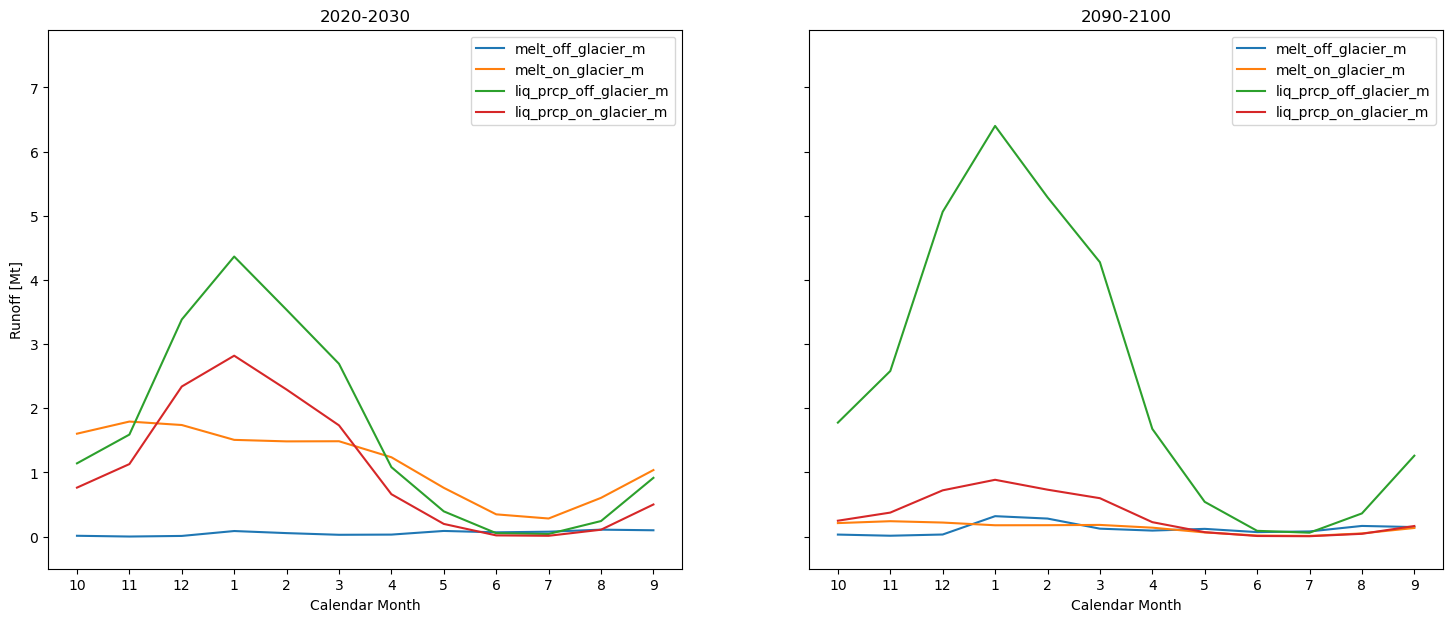

In [26]:
# Make this into a visual
runoff_variables = ['melt_off_glacier_m', 'melt_on_glacier_m', 'liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m']
s_keys = rtype_calc_s26.keys()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True);
# for r in runoff_variables:
#     runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s, r)
#     runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e, r)
#     xvals = np.asarray(season_t.index)+1
#     ax1.plot(xvals, runoff_s['mean'], label=r)
#     ax2.plot(xvals, runoff_e['mean'], label=r)

for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s26, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e26, r)
    xvals = index2
    ax1.plot(xvals, runoff_s['mean'], label=r)
    ax2.plot(xvals, runoff_e['mean'], label=r)
    
    # runoff_s['mean'].plot(x=xvals, ax=ax1, legend=False, title='Year 0-10')
    # runoff_e['mean'].plot(x=xvals, ax=ax2, title='Year 90-100')
#    ax.plot(xvals, runoff_s['mean'], ax=ax1, legend=False, title='Year 0-10')
#    ax.plot(xvals, runoff_e['mean'], ax=ax2, title='Year 90-100')
ax1.set(ylabel='Runoff [Mt]', title='2020-2030')
ax2.set(title='2090-2100')
# THIS WORKS
for ax in (ax1,ax2):
    ax.set(xticks = season_roll['month_2d'].values,
           xticklabels = season_roll2['month_2d'].values, #here, we want calendar year values
           xlabel = 'Calendar Month'
          );
    ax.legend();

# for ax in (ax1,ax2):
#     ax.set(xticks = season_roll['month_2d'].values,
#            xticklabels = (season_roll['calendar_month_2d'].values),
#            xlabel = 'Calendar Month'
#           );
#     ax.legend();

plt.ylim([-0.5,7.9]);
#plt.title = "Seasonal runoff averages by runoff type";

#plt.savefig('Figures/Seasonal/Decade_av/{}_decade_av_cycle_2023-03-09.png'.format(rcp), bbox_inches='tight')

### Calculate rcp45

In [27]:
# Make a dictionary with all data for all GCMs (this will only output one rcp!)
rcp_monthly_dict45 = {}

x=0
rcp = 'rcp45'

# Per rcp:
for gcm in gcm_list:
    if rcp != 'rcp60':
        rcp_value = open_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_rcp=rcp)
        k = '{}-{}'.format(gcm, rcp)
        rcp_monthly_dict45[k]=rcp_value
    else:
        if gcm in gcm_w60:
            rcp_value = open_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_rcp=rcp)
            k = '{}-{}'.format(gcm, rcp)
            rcp_monthly_dict45[k]=rcp_value
    x += 1

In [28]:
# Bring in your dictionary of unrolled values
season_unroll45 = {}
for k in rcp_monthly_dict45.keys():
    calculation = calc_seasonal(rcp_monthly_dict45[k])
    z = '{}-calc'.format(k)
    season_unroll45[z] = calculation

In [29]:
# define keys to use in next step
keys45 = season_unroll45.keys()

In [30]:
# Roll coordinates!
## Let's try directly assigning the coordinate used for plotting?
n_roll = 6 ## how many months to roll. 6 looks nice but you can choose

dict_roll45 = {}
dict_plot45 = {}

for k in keys45:
    season_roll = season_unroll45[k].roll(month_2d=n_roll, roll_coords=True)
    season_forplot = season_unroll45[k].roll(month_2d=n_roll, roll_coords=False)
    name = '{}'.format(k)
    dict_roll45[name] = season_roll
    dict_plot45[name] = season_forplot

In [31]:
# Roll and sum
rtype_roll45 = {}
n_roll = 6

for k in rcp_monthly_dict45.keys():
    rtype_season = rcp_monthly_dict45[k].roll(month_2d=n_roll, roll_coords=True)
    rtype_sum = rtype_season.sum(dim='rgi_id')
    rtype_name = '{}'.format(k)
    rtype_roll45[rtype_name] = rtype_sum

# Output is a dictionary with summed values!

In [32]:
rtype_roll45.keys()

dict_keys(['CCSM4-rcp45', 'CNRM-CM5-rcp45', 'CSIRO-Mk3-6-0-rcp45', 'CanESM2-rcp45', 'GFDL-CM3-rcp45', 'GFDL-ESM2G-rcp45', 'GISS-E2-R-rcp45', 'IPSL-CM5A-LR-rcp45', 'MPI-ESM-LR-rcp45', 'NorESM1-M-rcp45'])

In [33]:
rtype_calc_s45 = {}
rtype_calc_e45 = {}

for k in rtype_roll45.keys():
    df_key = rtype_roll45[k]
    df_m_s = df_key.isel(time=slice(0, 10)).mean(dim='time').to_dataframe() * 1e-9
    df_m_s.columns = [c.replace('_monthly', '_m') for c in df_m_s.columns]
    df_m_s = df_m_s.clip(0)
    calc_name = '{}'.format(k)
    rtype_calc_s45[calc_name] = df_m_s

for k in rtype_roll45.keys():
    df_key = rtype_roll45[k]
    df_m_e = df_key.isel(time=slice(-11, -1)).mean(dim='time').to_dataframe() * 1e-9
    df_m_e.columns = [c.replace('_monthly', '_m') for c in df_m_e.columns]
    df_m_e = df_m_e.clip(0)
    calc_name = '{}'.format(k)
    rtype_calc_e45[calc_name] = df_m_e
    

In [34]:
# IN USE: This is used for visualization of the 6-rolled hydro months, turns it into calendar months w/shift
season_roll2 = season_unroll45['CCSM4-rcp45-calc'].roll(month_2d=-3, roll_coords=True)

In [35]:
# IN USE: This is used for plotting of months with values 1-12
index1 = season_unroll45['CCSM4-rcp45-calc']
index2 = index1['month_2d']

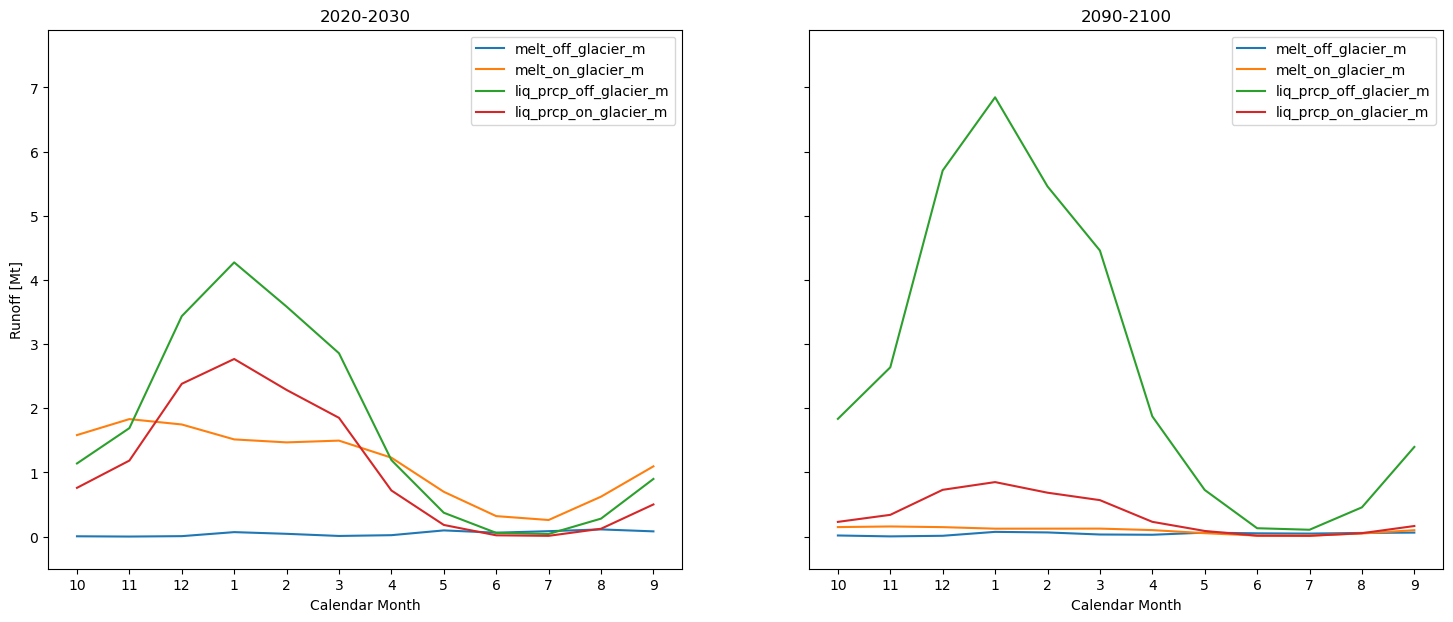

In [36]:
# Make this into a visual
runoff_variables = ['melt_off_glacier_m', 'melt_on_glacier_m', 'liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m']
s_keys = rtype_calc_s45.keys()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True);
# for r in runoff_variables:
#     runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s, r)
#     runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e, r)
#     xvals = np.asarray(season_t.index)+1
#     ax1.plot(xvals, runoff_s['mean'], label=r)
#     ax2.plot(xvals, runoff_e['mean'], label=r)

for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s45, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e45, r)
    xvals = index2
    ax1.plot(xvals, runoff_s['mean'], label=r)
    ax2.plot(xvals, runoff_e['mean'], label=r)
    
    # runoff_s['mean'].plot(x=xvals, ax=ax1, legend=False, title='Year 0-10')
    # runoff_e['mean'].plot(x=xvals, ax=ax2, title='Year 90-100')
#    ax.plot(xvals, runoff_s['mean'], ax=ax1, legend=False, title='Year 0-10')
#    ax.plot(xvals, runoff_e['mean'], ax=ax2, title='Year 90-100')
ax1.set(ylabel='Runoff [Mt]', title='2020-2030')
ax2.set(title='2090-2100')
# THIS WORKS
for ax in (ax1,ax2):
    ax.set(xticks = season_roll['month_2d'].values,
           xticklabels = season_roll2['month_2d'].values, #here, we want calendar year values
           xlabel = 'Calendar Month'
          );
    ax.legend();

# for ax in (ax1,ax2):
#     ax.set(xticks = season_roll['month_2d'].values,
#            xticklabels = (season_roll['calendar_month_2d'].values),
#            xlabel = 'Calendar Month'
#           );
#     ax.legend();

plt.ylim([-0.5,7.9]);
#plt.title = "Seasonal runoff averages by runoff type";

#plt.savefig('Figures/Seasonal/Decade_av/{}_decade_av_cycle_2023-03-09.png'.format(rcp), bbox_inches='tight')

### Calculate rcp60

In [37]:
# Make a dictionary with all data for all GCMs (this will only output one rcp!)
rcp_monthly_dict60 = {}

x=0
rcp = 'rcp60'

# Per rcp:
for gcm in gcm_list:
    if rcp != 'rcp60':
        rcp_value = open_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_rcp=rcp)
        k = '{}-{}'.format(gcm, rcp)
        rcp_monthly_dict60[k]=rcp_value
    else:
        if gcm in gcm_w60:
            rcp_value = open_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_rcp=rcp)
            k = '{}-{}'.format(gcm, rcp)
            rcp_monthly_dict60[k]=rcp_value
    x += 1

In [38]:
# Bring in your dictionary of unrolled values
season_unroll60 = {}
for k in rcp_monthly_dict60.keys():
    calculation = calc_seasonal(rcp_monthly_dict60[k])
    z = '{}-calc'.format(k)
    season_unroll60[z] = calculation

In [39]:
# define keys to use in next step
keys60 = season_unroll60.keys()

In [40]:
# Roll coordinates!
## Let's try directly assigning the coordinate used for plotting?
n_roll = 6 ## how many months to roll. 6 looks nice but you can choose

dict_roll60 = {}
dict_plot60 = {}

for k in keys60:
    season_roll = season_unroll60[k].roll(month_2d=n_roll, roll_coords=True)
    season_forplot = season_unroll60[k].roll(month_2d=n_roll, roll_coords=False)
    name = '{}'.format(k)
    dict_roll60[name] = season_roll
    dict_plot60[name] = season_forplot

In [41]:
# Roll and sum
rtype_roll60 = {}
n_roll = 6

for k in rcp_monthly_dict60.keys():
    rtype_season = rcp_monthly_dict60[k].roll(month_2d=n_roll, roll_coords=True)
    rtype_sum = rtype_season.sum(dim='rgi_id')
    rtype_name = '{}'.format(k)
    rtype_roll60[rtype_name] = rtype_sum

# Output is a dictionary with summed values!

In [42]:
rtype_roll60.keys()

dict_keys(['CCSM4-rcp60', 'CSIRO-Mk3-6-0-rcp60', 'GFDL-CM3-rcp60', 'GFDL-ESM2G-rcp60', 'GISS-E2-R-rcp60', 'IPSL-CM5A-LR-rcp60', 'NorESM1-M-rcp60'])

In [43]:
rtype_calc_s60 = {}
rtype_calc_e60 = {}

for k in rtype_roll60.keys():
    df_key = rtype_roll60[k]
    df_m_s = df_key.isel(time=slice(0, 10)).mean(dim='time').to_dataframe() * 1e-9
    df_m_s.columns = [c.replace('_monthly', '_m') for c in df_m_s.columns]
    df_m_s = df_m_s.clip(0)
    calc_name = '{}'.format(k)
    rtype_calc_s60[calc_name] = df_m_s

for k in rtype_roll60.keys():
    df_key = rtype_roll60[k]
    df_m_e = df_key.isel(time=slice(-11, -1)).mean(dim='time').to_dataframe() * 1e-9
    df_m_e.columns = [c.replace('_monthly', '_m') for c in df_m_e.columns]
    df_m_e = df_m_e.clip(0)
    calc_name = '{}'.format(k)
    rtype_calc_e60[calc_name] = df_m_e
    

In [44]:
# IN USE: This is used for visualization of the 6-rolled hydro months, turns it into calendar months w/shift
season_roll2 = season_unroll60['CCSM4-rcp60-calc'].roll(month_2d=-3, roll_coords=True)

In [45]:
# IN USE: This is used for plotting of months with values 1-12
index1 = season_unroll60['CCSM4-rcp60-calc']
index2 = index1['month_2d']

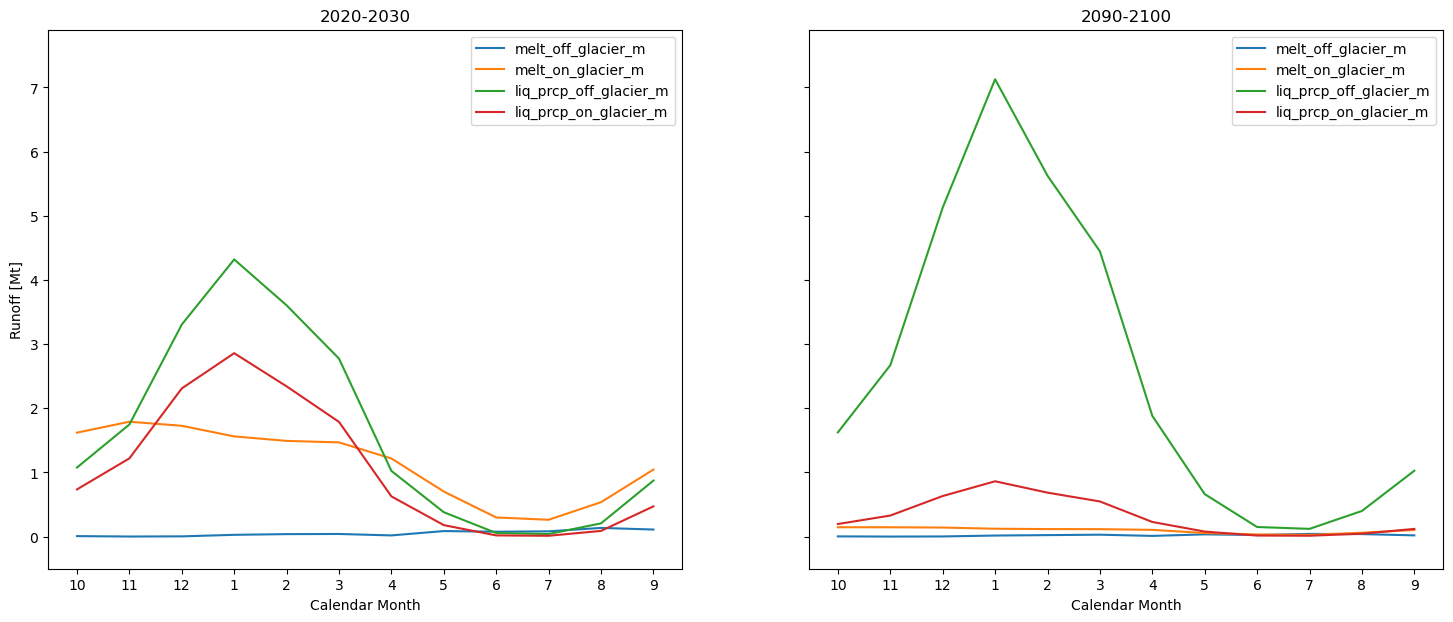

In [46]:
# Make this into a visual
runoff_variables = ['melt_off_glacier_m', 'melt_on_glacier_m', 'liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m']
s_keys = rtype_calc_s60.keys()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True);
# for r in runoff_variables:
#     runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s, r)
#     runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e, r)
#     xvals = np.asarray(season_t.index)+1
#     ax1.plot(xvals, runoff_s['mean'], label=r)
#     ax2.plot(xvals, runoff_e['mean'], label=r)

for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s60, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e60, r)
    xvals = index2
    ax1.plot(xvals, runoff_s['mean'], label=r)
    ax2.plot(xvals, runoff_e['mean'], label=r)
    
    # runoff_s['mean'].plot(x=xvals, ax=ax1, legend=False, title='Year 0-10')
    # runoff_e['mean'].plot(x=xvals, ax=ax2, title='Year 90-100')
#    ax.plot(xvals, runoff_s['mean'], ax=ax1, legend=False, title='Year 0-10')
#    ax.plot(xvals, runoff_e['mean'], ax=ax2, title='Year 90-100')
ax1.set(ylabel='Runoff [Mt]', title='2020-2030')
ax2.set(title='2090-2100')
# THIS WORKS
for ax in (ax1,ax2):
    ax.set(xticks = season_roll['month_2d'].values,
           xticklabels = season_roll2['month_2d'].values, #here, we want calendar year values
           xlabel = 'Calendar Month'
          );
    ax.legend();

# for ax in (ax1,ax2):
#     ax.set(xticks = season_roll['month_2d'].values,
#            xticklabels = (season_roll['calendar_month_2d'].values),
#            xlabel = 'Calendar Month'
#           );
#     ax.legend();

plt.ylim([-0.5,7.9]);
#plt.title = "Seasonal runoff averages by runoff type";

#plt.savefig('Figures/Seasonal/Decade_av/{}_decade_av_cycle_2023-03-09.png'.format(rcp), bbox_inches='tight')

### Calculate rcp85

In [47]:
# Make a dictionary with all data for all GCMs (this will only output one rcp!)
rcp_monthly_dict85 = {}

x=0
rcp = 'rcp85'

# Per rcp:
for gcm in gcm_list:
    if rcp != 'rcp60':
        rcp_value = open_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_rcp=rcp)
        k = '{}-{}'.format(gcm, rcp)
        rcp_monthly_dict85[k]=rcp_value
    else:
        if gcm in gcm_w60:
            rcp_value = open_series(fpath_stem=base, which_date=date_list[x], which_gcm=gcm, which_rcp=rcp)
            k = '{}-{}'.format(gcm, rcp)
            rcp_monthly_dict85[k]=rcp_value
    x += 1

In [48]:
# Bring in your dictionary of unrolled values
season_unroll85 = {}
for k in rcp_monthly_dict85.keys():
    calculation = calc_seasonal(rcp_monthly_dict85[k])
    z = '{}-calc'.format(k)
    season_unroll85[z] = calculation

In [49]:
# define keys to use in next step
keys85 = season_unroll85.keys()

In [50]:
# Roll coordinates!
## Let's try directly assigning the coordinate used for plotting?
n_roll = 6 ## how many months to roll. 6 looks nice but you can choose

dict_roll85 = {}
dict_plot85 = {}

for k in keys85:
    season_roll = season_unroll85[k].roll(month_2d=n_roll, roll_coords=True)
    season_forplot = season_unroll85[k].roll(month_2d=n_roll, roll_coords=False)
    name = '{}'.format(k)
    dict_roll85[name] = season_roll
    dict_plot85[name] = season_forplot

In [51]:
# Roll and sum
rtype_roll85 = {}
n_roll = 6

for k in rcp_monthly_dict85.keys():
    rtype_season = rcp_monthly_dict85[k].roll(month_2d=n_roll, roll_coords=True)
    rtype_sum = rtype_season.sum(dim='rgi_id')
    rtype_name = '{}'.format(k)
    rtype_roll85[rtype_name] = rtype_sum

# Output is a dictionary with summed values!

In [52]:
rtype_roll85.keys()

dict_keys(['CCSM4-rcp85', 'CNRM-CM5-rcp85', 'CSIRO-Mk3-6-0-rcp85', 'CanESM2-rcp85', 'GFDL-CM3-rcp85', 'GFDL-ESM2G-rcp85', 'GISS-E2-R-rcp85', 'IPSL-CM5A-LR-rcp85', 'MPI-ESM-LR-rcp85', 'NorESM1-M-rcp85'])

In [53]:
rtype_calc_s85 = {}
rtype_calc_e85 = {}

for k in rtype_roll85.keys():
    df_key = rtype_roll85[k]
    df_m_s = df_key.isel(time=slice(0, 10)).mean(dim='time').to_dataframe() * 1e-9
    df_m_s.columns = [c.replace('_monthly', '_m') for c in df_m_s.columns]
    df_m_s = df_m_s.clip(0)
    calc_name = '{}'.format(k)
    rtype_calc_s85[calc_name] = df_m_s

for k in rtype_roll85.keys():
    df_key = rtype_roll85[k]
    df_m_e = df_key.isel(time=slice(-11, -1)).mean(dim='time').to_dataframe() * 1e-9
    df_m_e.columns = [c.replace('_monthly', '_m') for c in df_m_e.columns]
    df_m_e = df_m_e.clip(0)
    calc_name = '{}'.format(k)
    rtype_calc_e85[calc_name] = df_m_e
    

In [54]:
# IN USE: This is used for visualization of the 6-rolled hydro months, turns it into calendar months w/shift
season_roll2 = season_unroll85['CCSM4-rcp85-calc'].roll(month_2d=-3, roll_coords=True)

In [55]:
# IN USE: This is used for plotting of months with values 1-12
index1 = season_unroll85['CCSM4-rcp85-calc']
index2 = index1['month_2d']

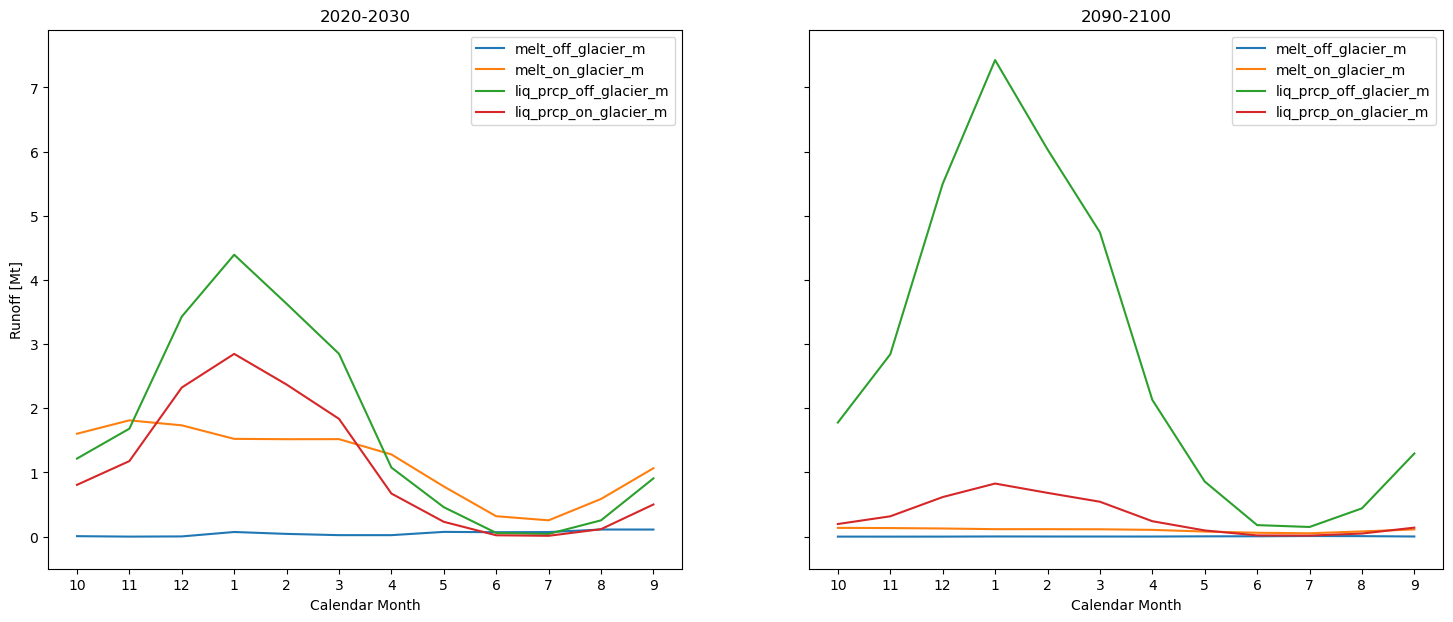

In [56]:
# Make this into a visual
runoff_variables = ['melt_off_glacier_m', 'melt_on_glacier_m', 'liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m']
s_keys = rtype_calc_s85.keys()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True);
# for r in runoff_variables:
#     runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s, r)
#     runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e, r)
#     xvals = np.asarray(season_t.index)+1
#     ax1.plot(xvals, runoff_s['mean'], label=r)
#     ax2.plot(xvals, runoff_e['mean'], label=r)

for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s85, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e85, r)
    xvals = index2
    ax1.plot(xvals, runoff_s['mean'], label=r)
    ax2.plot(xvals, runoff_e['mean'], label=r)
    
    # runoff_s['mean'].plot(x=xvals, ax=ax1, legend=False, title='Year 0-10')
    # runoff_e['mean'].plot(x=xvals, ax=ax2, title='Year 90-100')
#    ax.plot(xvals, runoff_s['mean'], ax=ax1, legend=False, title='Year 0-10')
#    ax.plot(xvals, runoff_e['mean'], ax=ax2, title='Year 90-100')
ax1.set(ylabel='Runoff [Mt]', title='2020-2030')
ax2.set(title='2090-2100')
# THIS WORKS
for ax in (ax1,ax2):
    ax.set(xticks = season_roll['month_2d'].values,
           xticklabels = season_roll2['month_2d'].values, #here, we want calendar year values
           xlabel = 'Calendar Month'
          );
    ax.legend();

# for ax in (ax1,ax2):
#     ax.set(xticks = season_roll['month_2d'].values,
#            xticklabels = (season_roll['calendar_month_2d'].values),
#            xlabel = 'Calendar Month'
#           );
#     ax.legend();

plt.ylim([-0.5,7.9]);
#plt.title = "Seasonal runoff averages by runoff type";

#plt.savefig('Figures/Seasonal/Decade_av/{}_decade_av_cycle_2023-03-09.png'.format(rcp), bbox_inches='tight')

# Visualize time slices!

In [203]:
# This is now outdated (only shows 1 rcp)

# ## New loop that gives multiple time slices
# # Visualizations
# keys = season_unroll60.keys()

# time = [0, 30, 55, 80]

# fig, ax = plt.subplots()
# for t in time:
#     season_t = season_sliced(keys, dict_roll60, t)
#     xvals = np.asarray(season_t.index)+1 ## wants to plot according to DataFrame index, but this is 0-indexed (Pandas dataframe) rather than 1-indexed (xarray months)
#     ax.plot(xvals, season_t['mean'], label=t+2020);
# ax.set(xticks = season_roll['month_2d'].values,
#        xticklabels = season_roll['calendar_month_2d'].values,
#        xlabel = 'Month',
#        ylabel = 'Runoff [Mt]',
#        title = 'Annual runoff cycle {}'.format(rcp));
# ax.legend();
# plt.ylim([-0.3,10.2]);

# #plt.savefig('Figures/Seasonal/Slice/{}_annual_cycle_2023-03-09.png'.format(rcp), bbox_inches='tight')

In [53]:
key_dict = {}

key_dict['rcp26'] = season_unroll26.keys()
key_dict['rcp45'] = season_unroll45.keys()
key_dict['rcp60'] = season_unroll60.keys()
key_dict['rcp85'] = season_unroll85.keys()

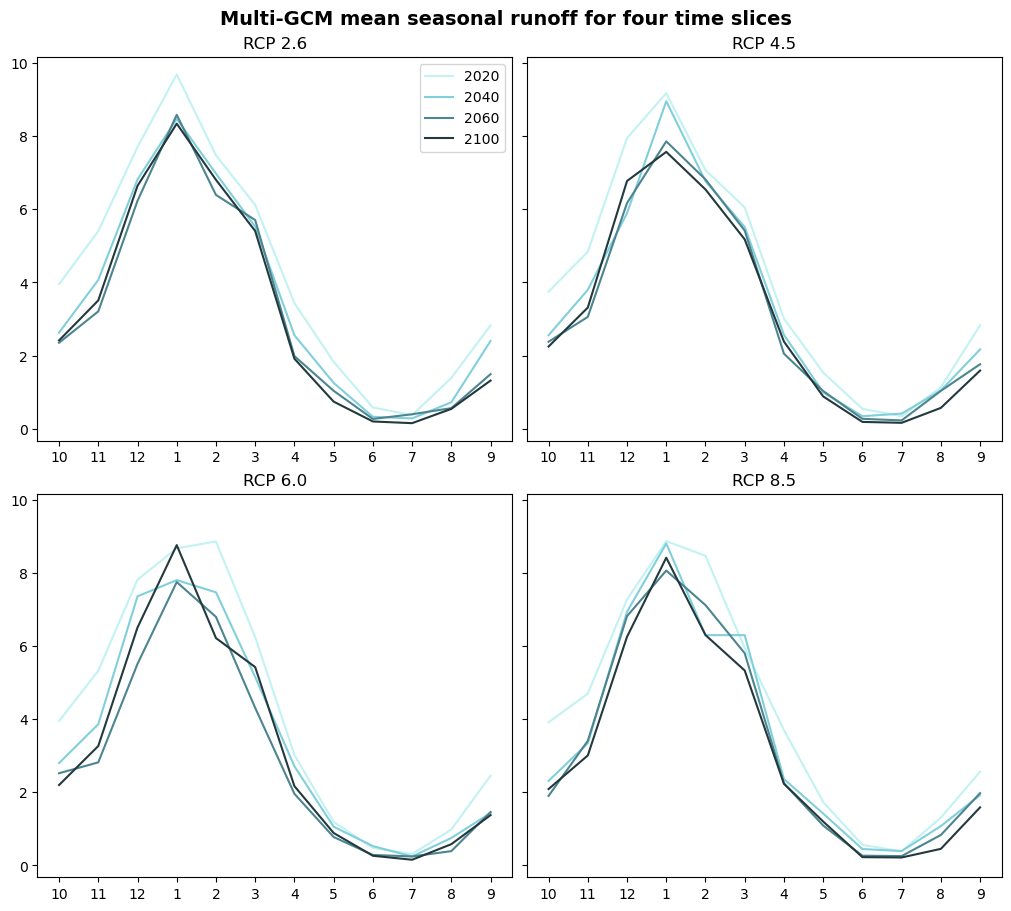

In [506]:
# Let's try to get this to show each GCM as well as means!
time = [0, 20, 40, 80]

# from matplotlib import cm
# color_ts = cm.get_cmap('twilight')

color_ts = ('#c2f2f2', '#81cfdb', '#4c858f', '#23393d')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 9), sharey=True, constrained_layout = True)       

t_idx=0
for t in time:
    season_t = season_sliced(key_dict['rcp26'], dict_roll26, t)
    xvals = np.asarray(season_t.index)+1
    ax1.plot(xvals, season_t['mean'], label=t+2020, color=color_ts[t_idx])
    t_idx = t_idx + 1

t_idx=0
for t in time:
    season_t = season_sliced(key_dict['rcp45'], dict_roll45, t)
    xvals = np.asarray(season_t.index)+1
    ax2.plot(xvals, season_t['mean'], label=t+2020, color=color_ts[t_idx])
    t_idx = t_idx + 1

t_idx=0
for t in time:
    season_t = season_sliced(key_dict['rcp60'], dict_roll60, t)
    xvals = np.asarray(season_t.index)+1
    ax3.plot(xvals, season_t['mean'], label=t+2020, color=color_ts[t_idx])
    t_idx = t_idx + 1
    
t_idx=0
for t in time:
    season_t = season_sliced(key_dict['rcp85'], dict_roll85, t)
    xvals = np.asarray(season_t.index)+1
    ax4.plot(xvals, season_t['mean'], label=t+2020, color=color_ts[t_idx])
    t_idx = t_idx + 1

ax1.set(xticks = season_roll['month_2d'].values,
       xticklabels = season_roll2['month_2d'].values,
       title = 'RCP 2.6');
ax2.set(xticks = season_roll['month_2d'].values,
       xticklabels = season_roll2['month_2d'].values,
       title = 'RCP 4.5');
ax3.set(xticks = season_roll['month_2d'].values,
       xticklabels = season_roll2['month_2d'].values,
       title = 'RCP 6.0');
ax4.set(xticks = season_roll['month_2d'].values,
       xticklabels = season_roll2['month_2d'].values,
       title = 'RCP 8.5');
ax1.legend();

plt.suptitle('Multi-GCM mean seasonal runoff for four time slices', fontweight = 'bold', fontsize = 14);

#plt.savefig('Figures/Seasonal/Slice/all_rcps_four_slices_2x2', bbox_inches='tight')

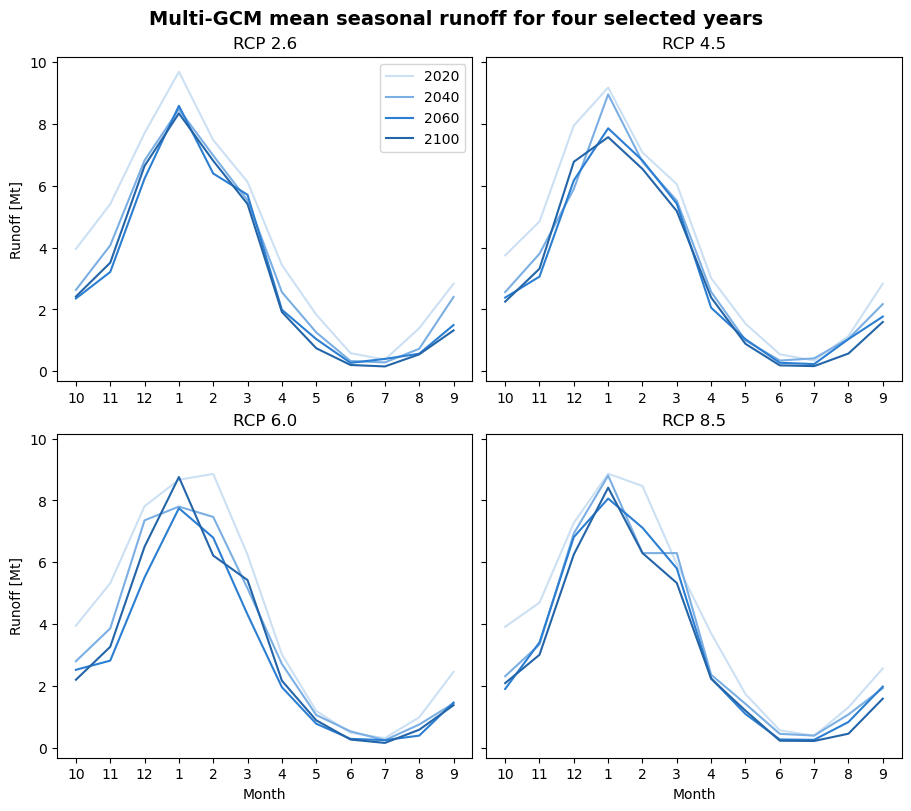

In [515]:
# Let's try to get this to show each GCM as well as means!
time = [0, 20, 40, 80]

# from matplotlib import cm
# color_ts = cm.get_cmap('twilight')

color_ts = ('#cce0f4', '#7bafe3', '#2b7ed1', '#2365a8')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 8), sharey=True, constrained_layout = True)       

t_idx=0
for t in time:
    season_t = season_sliced(key_dict['rcp26'], dict_roll26, t)
    xvals = np.asarray(season_t.index)+1
    ax1.plot(xvals, season_t['mean'], label=t+2020, color=color_ts[t_idx])
    t_idx = t_idx + 1

t_idx=0
for t in time:
    season_t = season_sliced(key_dict['rcp45'], dict_roll45, t)
    xvals = np.asarray(season_t.index)+1
    ax2.plot(xvals, season_t['mean'], label=t+2020, color=color_ts[t_idx])
    t_idx = t_idx + 1

t_idx=0
for t in time:
    season_t = season_sliced(key_dict['rcp60'], dict_roll60, t)
    xvals = np.asarray(season_t.index)+1
    ax3.plot(xvals, season_t['mean'], label=t+2020, color=color_ts[t_idx])
    t_idx = t_idx + 1
    
t_idx=0
for t in time:
    season_t = season_sliced(key_dict['rcp85'], dict_roll85, t)
    xvals = np.asarray(season_t.index)+1
    ax4.plot(xvals, season_t['mean'], label=t+2020, color=color_ts[t_idx])
    t_idx = t_idx + 1

ax1.set(xticks = season_roll['month_2d'].values,
        xticklabels = season_roll2['month_2d'].values,
        title = 'RCP 2.6',
        ylabel = 'Runoff [Mt]');
ax2.set(xticks = season_roll['month_2d'].values,
        xticklabels = season_roll2['month_2d'].values,
        title = 'RCP 4.5');
ax3.set(xticks = season_roll['month_2d'].values,
        ylabel = 'Runoff [Mt]',
        xticklabels = season_roll2['month_2d'].values,
        title = 'RCP 6.0',
        xlabel = 'Month');
ax4.set(xticks = season_roll['month_2d'].values,
        xticklabels = season_roll2['month_2d'].values,
        title = 'RCP 8.5',
        xlabel = 'Month');
ax1.legend();

plt.suptitle('Multi-GCM mean seasonal runoff for four selected years', fontweight = 'bold', fontsize = 14);

#plt.savefig('Figures/Seasonal/Slice/all_rcps_four_years_may4.png', bbox_inches='tight')

## <i> Visualizing time slices with mean values from + and - 2 years <br>
    It doesnt fucking work

Need to divide this into a dictionary with 4 sub-dictionaries: one for each time slice. Within each sub-dictionary, I want to have 4 sub-dictionaries correspoding to the RCP scenario. Within each of these sub-dictionaries, I want to have a dictionary of each GCM

In [580]:
# Make a big dictionary for all times
times = [2, 20, 40, 78]

for t in times:
    for k in keys_all:
        df_key = rtype_all[k]
        df_m_s = df_key.isel(time=slice(t-1, t+2)).mean(dim='time').to_dataframe() * 1e-9
        df_m_s = df_m_s.clip(0)
        calc_name = '{}-{}'.format(k, t)
        times_all[calc_name] = df_m_s

In [581]:
times_all.keys()

dict_keys(['CCSM4-rcp26-2', 'CNRM-CM5-rcp26-2', 'CSIRO-Mk3-6-0-rcp26-2', 'CanESM2-rcp26-2', 'GFDL-CM3-rcp26-2', 'GFDL-ESM2G-rcp26-2', 'GISS-E2-R-rcp26-2', 'IPSL-CM5A-LR-rcp26-2', 'MPI-ESM-LR-rcp26-2', 'NorESM1-M-rcp26-2', 'CCSM4-rcp45-2', 'CNRM-CM5-rcp45-2', 'CSIRO-Mk3-6-0-rcp45-2', 'CanESM2-rcp45-2', 'GFDL-CM3-rcp45-2', 'GFDL-ESM2G-rcp45-2', 'GISS-E2-R-rcp45-2', 'IPSL-CM5A-LR-rcp45-2', 'MPI-ESM-LR-rcp45-2', 'NorESM1-M-rcp45-2', 'CCSM4-rcp60-2', 'CSIRO-Mk3-6-0-rcp60-2', 'GFDL-CM3-rcp60-2', 'GFDL-ESM2G-rcp60-2', 'GISS-E2-R-rcp60-2', 'IPSL-CM5A-LR-rcp60-2', 'NorESM1-M-rcp60-2', 'CCSM4-rcp85-2', 'CNRM-CM5-rcp85-2', 'CSIRO-Mk3-6-0-rcp85-2', 'CanESM2-rcp85-2', 'GFDL-CM3-rcp85-2', 'GFDL-ESM2G-rcp85-2', 'GISS-E2-R-rcp85-2', 'IPSL-CM5A-LR-rcp85-2', 'MPI-ESM-LR-rcp85-2', 'NorESM1-M-rcp85-2', 'CCSM4-rcp26-20', 'CNRM-CM5-rcp26-20', 'CSIRO-Mk3-6-0-rcp26-20', 'CanESM2-rcp26-20', 'GFDL-CM3-rcp26-20', 'GFDL-ESM2G-rcp26-20', 'GISS-E2-R-rcp26-20', 'IPSL-CM5A-LR-rcp26-20', 'MPI-ESM-LR-rcp26-20', 'NorESM

In [583]:
# Make a dictionary with sub-dictionaries corresponding to time, rcp, and gcm
rcps = ['rcp26', 'rcp45', 'rcp60', 'rcp85']
gcms = ['CCSM4', 'CNRM-CM5', 'CSIRO-Mk3-6-0', 'CanESM2', 'GFDL-CM3', 'GFDL-ESM2G', 'GISS-E2-R', 'IPSL-CM5A-LR', 'MPI-ESM-LR', 'NorESM1-M']
time = [2, 20, 40, 78]
gcm60 = ['CCSM4', 'CSIRO-Mk3-6-0', 'GFDL-CM3', 'GFDL-ESM2G', 'GISS-E2-R', 'IPSL-CM5A-LR', 'NorESM1-M']

dict_gcm = {}
dict_rcp = {}
dict_time = {}

# The values are all the same - why is this?
for t in times:
    for r in rcps:
        if r != 'rcp60':
            for g in gcms:
                dict_gcm['{}-{}'.format(g, r)] = times_all['{}-{}-{}'.format(g, r, t)]
        else:
            for g6 in gcm60:
                dict_gcm['{}-{}'.format(g6, r)] = times_all['{}-{}-{}'.format(g6, r, t)]
        dict_rcp['{}'.format(r)] = dict_gcm
    dict_time['{}'.format(t)] = dict_rcp

In [592]:
dict_gcm

{'CCSM4-rcp26':           calendar_month_2d   volume  volume_bsl  volume_bwl      area  \
 month_2d                                                                 
 7              1.000000e-08  0.23588         0.0         0.0  0.003523   
 8              1.100000e-08  0.23588         0.0         0.0  0.003523   
 9              1.200000e-08  0.23588         0.0         0.0  0.003523   
 10             1.000000e-09  0.23588         0.0         0.0  0.003523   
 11             2.000000e-09  0.23588         0.0         0.0  0.003523   
 12             3.000000e-09  0.23588         0.0         0.0  0.003523   
 1              4.000000e-09  0.23588         0.0         0.0  0.003523   
 2              5.000000e-09  0.23588         0.0         0.0  0.003523   
 3              6.000000e-09  0.23588         0.0         0.0  0.003523   
 4              7.000000e-09  0.23588         0.0         0.0  0.003523   
 5              8.000000e-09  0.23588         0.0         0.0  0.003523   
 6        

In [591]:
times_all['CCSM4-rcp60-2']

,calendar_month_2d,volume,volume_bsl,volume_bwl,area,length,calving,calving_rate,off_area,on_area,...,snowfall_on_glacier,melt_off_glacier_monthly,melt_on_glacier_monthly,liq_prcp_off_glacier_monthly,liq_prcp_on_glacier_monthly,snowfall_off_glacier_monthly,snowfall_on_glacier_monthly,water_level,glen_a,fs
month_2d,,,,,,,,,,,,,,,,,,,,,
7,1.000000e-08,0.497119,0.0,0.0,0.011723,0.000018,0.0,0.0,0.011679,0.011723,...,3.556567,0.041274,1.666857,1.188703,0.983432,0.021679,0.247526,0.0,3.500746e-32,1.539000e-27
8,1.100000e-08,0.497119,0.0,0.0,0.011723,0.000018,0.0,0.0,0.011679,0.011723,...,3.556567,0.003273,2.097808,1.519765,1.382647,0.000688,0.147572,0.0,3.500746e-32,1.539000e-27
9,1.200000e-08,0.497119,0.0,0.0,0.011723,0.000018,0.0,0.0,0.011679,0.011723,...,3.556567,0.001078,2.055063,3.226365,2.918255,0.001539,0.339270,0.0,3.500746e-32,1.539000e-27
10,1.000000e-09,0.497119,0.0,0.0,0.011723,0.000018,0.0,0.0,0.011679,0.011723,...,3.556567,0.001103,1.977897,4.711024,4.196723,0.001878,0.522279,0.0,3.500746e-32,1.539000e-27
11,2.000000e-09,0.497119,0.0,0.0,0.011723,0.000018,0.0,0.0,0.011679,0.011723,...,3.556567,0.004179,1.928113,3.651355,3.237942,0.004710,0.437389,0.0,3.500746e-32,1.539000e-27
12,3.000000e-09,0.497119,0.0,0.0,0.011723,0.000018,0.0,0.0,0.011679,0.011723,...,3.556567,0.004187,1.788376,2.631777,2.180260,0.004848,0.396471,0.0,3.500746e-32,1.539000e-27
1,4.000000e-09,0.497119,0.0,0.0,0.011723,0.000018,0.0,0.0,0.011679,0.011723,...,3.556567,0.009940,1.464638,1.165751,0.914524,0.015371,0.267732,0.0,3.500746e-32,1.539000e-27
2,5.000000e-09,0.497119,0.0,0.0,0.011723,0.000018,0.0,0.0,0.011679,0.011723,...,3.556567,0.076899,0.785217,0.332480,0.198569,0.088741,0.220572,0.0,3.500746e-32,1.539000e-27
3,6.000000e-09,0.497119,0.0,0.0,0.011723,0.000018,0.0,0.0,0.011679,0.011723,...,3.556567,0.066661,0.320208,0.039065,0.013126,0.072625,0.100648,0.0,3.500746e-32,1.539000e-27


In [589]:
dict_time['2']['rcp85']['CCSM4-rcp85']

,calendar_month_2d,volume,volume_bsl,volume_bwl,area,length,calving,calving_rate,off_area,on_area,...,snowfall_on_glacier,melt_off_glacier_monthly,melt_on_glacier_monthly,liq_prcp_off_glacier_monthly,liq_prcp_on_glacier_monthly,snowfall_off_glacier_monthly,snowfall_on_glacier_monthly,water_level,glen_a,fs
month_2d,,,,,,,,,,,,,,,,,,,,,
7,1.000000e-08,0.19324,0.0,0.0,0.002365,0.000006,0.0,0.0,0.021037,0.002365,...,0.051038,0.000405,0.127569,2.180995,0.243458,0.000147,0.000788,0.0,3.500746e-32,1.539000e-27
8,1.100000e-08,0.19324,0.0,0.0,0.002365,0.000006,0.0,0.0,0.021037,0.002365,...,0.051038,0.000000,0.130816,2.613824,0.295105,0.000000,0.000763,0.0,3.500746e-32,1.539000e-27
9,1.200000e-08,0.19324,0.0,0.0,0.002365,0.000006,0.0,0.0,0.021037,0.002365,...,0.051038,0.000525,0.122006,5.067669,0.574902,0.000525,0.003507,0.0,3.500746e-32,1.539000e-27
10,1.000000e-09,0.19324,0.0,0.0,0.002365,0.000006,0.0,0.0,0.021037,0.002365,...,0.051038,0.002567,0.111308,9.138851,1.028918,0.003354,0.010497,0.0,3.500746e-32,1.539000e-27
11,2.000000e-09,0.19324,0.0,0.0,0.002365,0.000006,0.0,0.0,0.021037,0.002365,...,0.051038,0.003317,0.105898,8.396564,0.955354,0.004081,0.011592,0.0,3.500746e-32,1.539000e-27
12,3.000000e-09,0.19324,0.0,0.0,0.002365,0.000006,0.0,0.0,0.021037,0.002365,...,0.051038,0.003100,0.100401,4.513866,0.522140,0.002783,0.006425,0.0,3.500746e-32,1.539000e-27
1,4.000000e-09,0.19324,0.0,0.0,0.002365,0.000006,0.0,0.0,0.021037,0.002365,...,0.051038,0.002353,0.095750,1.870747,0.212517,0.001661,0.004099,0.0,3.500746e-32,1.539000e-27
2,5.000000e-09,0.19324,0.0,0.0,0.002365,0.000006,0.0,0.0,0.021037,0.002365,...,0.051038,0.012679,0.045946,0.512375,0.058795,0.012799,0.002241,0.0,3.500746e-32,1.539000e-27
3,6.000000e-09,0.19324,0.0,0.0,0.002365,0.000006,0.0,0.0,0.021037,0.002365,...,0.051038,0.015656,0.020110,0.262698,0.028605,0.015546,0.001484,0.0,3.500746e-32,1.539000e-27


In [470]:
def seasonal_sum(this_ds):
    melt1 = this_ds.melt_on_glacier_monthly
    melt2 = this_ds.melt_off_glacier_monthly
    melt3 = this_ds.liq_prcp_off_glacier_monthly
    melt4 = this_ds.liq_prcp_on_glacier_monthly
    
    this_sum = melt1 + melt2 + melt3 + melt4

    return this_sum

In [471]:
# Make the same dictionary as above but find mean total runoff
# dict_r_gcm = {}
# dict_r_rcp = {}
# dict_r_t = {}

# for t in times:
#     for r in rcps:
#         if r != 'rcp60':
#             for g in gcms:
#                 runoff_sum = seasonal_sum(times_all['{}-{}-{}'.format(g, r, t)])
#                 dict_r_gcm['{}'.format(g)] = runoff_sum
#         else:
#             for g6 in gcm60:
#                 runoff_sum = seasonal_sum(times_all['{}-{}-{}'.format(g6, r, t)])
#                 dict_r_gcm['{}'.format(g6)] = runoff_sum
#         for k in dict_r_gcm.keys():
#             new = dict_r_gcm[k]
#             new = pd.DataFrame(new)
#         dict_r_gcm['mean'] = new
#         dict_r_rcp['{}'.format(r)] = dict_r_gcm
#     dict_r_t['{}'.format(t)] = dict_r_rcp

In [472]:
# dict_r_t['2']['rcp26']['mean']

,0
month_2d,
7,3.461769
8,4.836188
9,7.719016
10,7.162597
11,7.575622
12,6.577529
1,3.619528
2,1.046853
3,0.350693


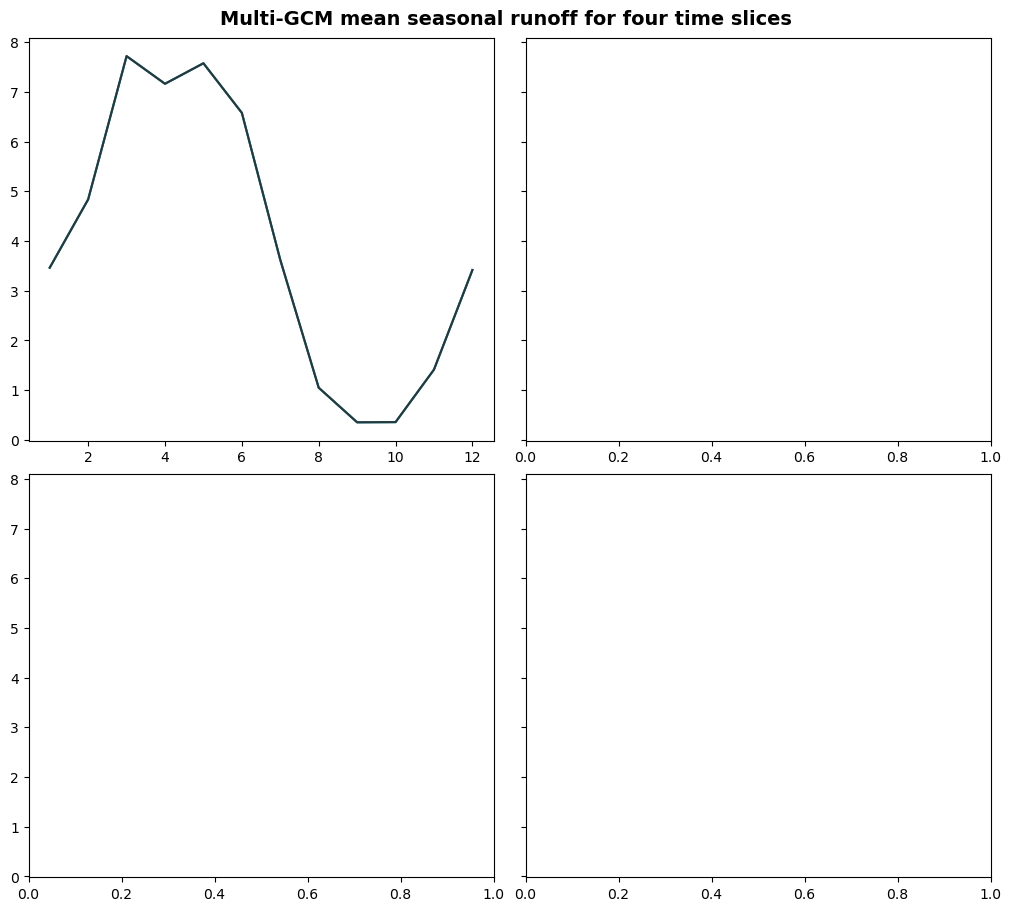

In [474]:
# Try graphing this
color_ts = ('#c2f2f2', '#81cfdb', '#4c858f', '#23393d')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 9), sharey=True, constrained_layout = True)       

t_idx=0
for t in times:
    means = dict_r_t['{}'.format(t)]['rcp26']['mean']
    xvals = np.asarray(season_t.index)+1
    ax1.plot(xvals, means, label=t+2020, color=color_ts[t_idx])
    t_idx = t_idx + 1

# t_idx=0
# for t in times:
#     means = dict_r_t['{}'.format(t)]['rcp45']['mean']
#     xvals = np.asarray(season_t.index)+1
#     ax2.plot(xvals, means, label=t+2020, color=color_ts[t_idx])
#     t_idx = t_idx + 1
    
# t_idx=0
# for t in times:
#     means = dict_r_t['{}'.format(t)]['rcp60']['mean']
#     xvals = np.asarray(season_t.index)+1
#     ax3.plot(xvals, means, label=t+2020, color=color_ts[t_idx])
#     t_idx = t_idx + 1
    
# t_idx=0
# for t in times:
#     means = dict_r_t['{}'.format(t)]['rcp85']['mean']
#     xvals = np.asarray(season_t.index)+1
#     ax4.plot(xvals, means, label=t+2020, color=color_ts[t_idx])
#     t_idx = t_idx + 1

# ax1.set(xticks = season_roll['month_2d'].values,
#        xticklabels = season_roll2['month_2d'].values,
#        title = 'RCP 2.6');
# ax2.set(xticks = season_roll['month_2d'].values,
#        xticklabels = season_roll2['month_2d'].values,
#        title = 'RCP 4.5');
# ax3.set(xticks = season_roll['month_2d'].values,
#        xticklabels = season_roll2['month_2d'].values,
#        title = 'RCP 6.0');
# ax4.set(xticks = season_roll['month_2d'].values,
#        xticklabels = season_roll2['month_2d'].values,
#        title = 'RCP 8.5');
# ax1.legend();

plt.suptitle('Multi-GCM mean seasonal runoff for four time slices', fontweight = 'bold', fontsize = 14);

In [ ]:
# for t in time:
#     season_t = season_sliced(key_dict['rcp26'], dict_roll26, t)
#     xvals = np.asarray(season_t.index)+1
#     ax1.plot(xvals, season_t['mean'], label=t+2020, color=color_ts[t_idx])
#     t_idx = t_idx + 1
    
#     # Function: select a year and take the mean runoff of all gcms for this year
# def season_sliced(keys, dictionary, time):
#     new_df = pd.DataFrame()
#     for k in keys:
#         new = dictionary[k]
#         new = new[time]
#         new = pd.DataFrame(new)
#         new_df[k] = new
#     new_df['mean'] = new_df.transpose().mean()
#     return new_df

In [ ]:
# def rtype_calc_monthly_2vars(keys, dictionary, runoff1, runoff2):
#     dataframe = pd.DataFrame()
#     for k in keys:
#         rtype_gcm = dictionary[k]
#         rtype1 = rtype_gcm[runoff1]
#         rtype2 = rtype_gcm[runoff2]
#         rsum = rtype1 + rtype2
#         rtype_sum = pd.DataFrame(rsum)
#         dataframe[k] = rtype_sum
#     dataframe['mean'] = dataframe.transpose().mean()
#     return dataframe

In [443]:
rtype_all

{'CCSM4-rcp26': <xarray.Dataset>
 Dimensions:                       (time: 82, month_2d: 12)
 Coordinates:
   * time                          (time) float64 2.02e+03 ... 2.101e+03
     hydro_year                    (time) int64 2020 2021 2022 ... 2099 2100 2101
     hydro_month                   (time) int64 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
     calendar_year                 (time) int64 2019 2020 2021 ... 2098 2099 2100
     calendar_month                (time) int64 4 4 4 4 4 4 4 4 ... 4 4 4 4 4 4 4
   * month_2d                      (month_2d) int64 7 8 9 10 11 12 1 2 3 4 5 6
     calendar_month_2d             (month_2d) int64 10 11 12 1 2 3 4 5 6 7 8 9
 Data variables: (12/24)
     volume                        (time) float32 5.259e+08 ... 2.355e+08
     volume_bsl                    (time) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
     volume_bwl                    (time) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
     area                          (time) float32 1.31e+07 ... 3.696e+0

In [ ]:
# for r in runoff_variables:
#     runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s26, r)
#     runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e26, r)
#     xvals = index2
#     ax1.plot(xvals, runoff_s['mean'], label=r, color=color_m[ct])
#     ax2.plot(xvals, runoff_e['mean'], label=r, color=color_m[ct])
#     ct=ct+1
# runoff_s = rtype_calc_monthly_2vars(s_keys, rtype_calc_s26, sum_vars[0], sum_vars[1])
# runoff_e = rtype_calc_monthly_2vars(s_keys, rtype_calc_e26, sum_vars[0], sum_vars[1])
# xvals = index2

### <i> Calculations of slice means and ranges! (Updated 5/1)

In [125]:
def calc_month_av(dataframe):
    key = dataframe.keys()
    array = []
    for k in key:
        select_gcm = dataframe['{}'.format(k)]
        month_index = np.argmax(select_gcm)
        array.append(month_index)
    mean = (sum(array)/len(key))-2
    return mean

In [160]:
def calc_range(dataframe, mean_idx):
    mean_rd = int(mean_idx.round())+2
    df_peak = dataframe.iloc[mean_rd]
    min_val = min(df_peak)
    max_val = max(df_peak)
    range_val = max_val - min_val
    return range_val

#### <b> RCP2.6

In [ ]:
av_26_0 = season_sliced(season_unroll26.keys(), dict_roll26, 0)

In [164]:
av_26_0_drop = av_26_0.drop('mean', axis = 'columns')

In [168]:
av = calc_month_av(av_26_0_drop)

In [169]:
calc_range(av_26_0_drop, av)

3.4120960235595703

In [170]:
av_26_20 = season_sliced(season_unroll26.keys(), dict_roll26, 20)

In [171]:
av_26_20_drop = av_26_20.drop('mean', axis = 'columns')

In [172]:
av = calc_month_av(av_26_20_drop)

In [173]:
calc_range(av_26_20_drop, av)

5.060277938842773

In [174]:
av_26_40 = season_sliced(season_unroll26.keys(), dict_roll26, 40)

In [175]:
av_26_40_drop = av_26_40.drop('mean', axis = 'columns')

In [176]:
av = calc_month_av(av_26_40_drop)

In [177]:
calc_range(av_26_40_drop, av)

3.280426025390625

In [178]:
av_26_80 = season_sliced(season_unroll26.keys(), dict_roll26, 80)

In [179]:
av_26_80_drop = av_26_80.drop('mean', axis = 'columns')

In [180]:
av = calc_month_av(av_26_80_drop)

In [181]:
calc_range(av_26_80_drop, av)

5.341714382171631

#### <b> RCP 2.6

In [237]:
# Same as above, but in easier format?

In [350]:
timezzz = 80

In [351]:
av_26 = season_sliced(season_unroll26.keys(), dict_roll26, timezzz)

In [352]:
av_26_drop = av_26.drop('mean', axis = 'columns')

In [353]:
av26 = calc_month_av(av_26_drop)
av26

0.8999999999999999

In [354]:
calc_range(av_45_drop, av26)

6.348759174346924

#### <b> RCP 4.5

In [355]:
av_45 = season_sliced(season_unroll45.keys(), dict_roll45, timezzz)

In [356]:
av_45_drop = av_45.drop('mean', axis = 'columns')

In [357]:
av45 = calc_month_av(av_45_drop)
av45

0.8999999999999999

In [358]:
calc_range(av_45_drop, av45)

5.051761150360107

#### <b> RCP 6.0

In [359]:
av_60 = season_sliced(season_unroll60.keys(), dict_roll60, timezzz)

In [360]:
av_60_drop = av_60.drop('mean', axis = 'columns')

In [361]:
av60 = calc_month_av(av_60_drop)
av60

0.8571428571428572

In [362]:
calc_range(av_60_drop, av60)

5.2920637130737305

#### <b> RCP 8.5

In [363]:
av_85 = season_sliced(season_unroll85.keys(), dict_roll85, timezzz)

In [364]:
av_85_drop = av_85.drop('mean', axis = 'columns')

In [365]:
av85 = calc_month_av(av_85_drop)
av85

0.8999999999999999

In [366]:
calc_range(av_85_drop, av85)

7.977897644042969

#### <b> RCP spread

In [367]:
rcp26_slice = av_26['mean'].iloc[int(av26.round())+2]
rcp26_slice

8.341295

In [368]:
rcp45_slice = av_45['mean'].iloc[int(av45.round())+2]
rcp45_slice

7.570315

In [369]:
rcp60_slice = av_60['mean'].iloc[int(av60.round())+2]
rcp60_slice

8.757173

In [370]:
rcp85_slice = av_85['mean'].iloc[int(av85.round())+2]
rcp85_slice

8.41278

In [371]:
rcp60_slice - rcp45_slice

1.1868577

Note: in the case of season_calcs_rolled, the first month (0) is october, so month 3 is January

Find average month of peak runoff for RCP2.6 across all GCMs

## The section below this works!

This first chunk of code doesn't have updated colors, use the next one!

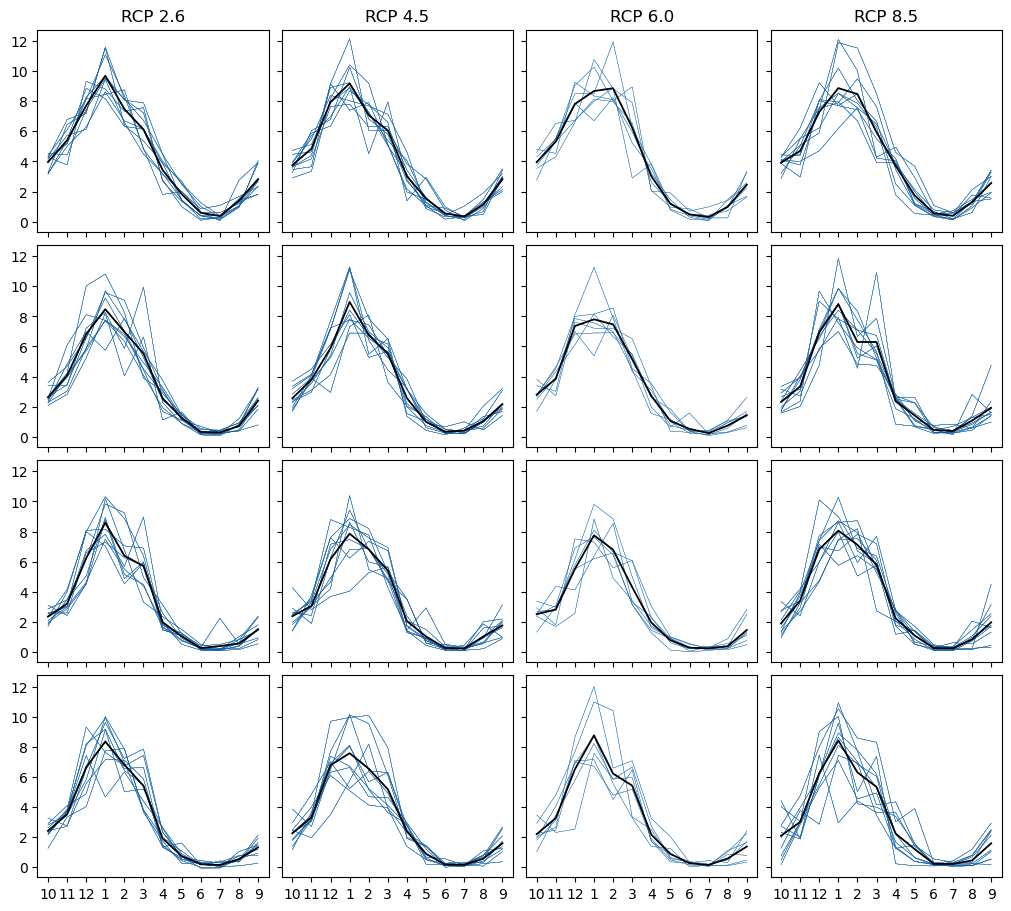

In [56]:
# Let's try to get this to show each GCM as well as means!
time = [0, 20, 40, 80]

from matplotlib import cm
color_ts = cm.get_cmap('Blues')

fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12), (ax13, ax14, ax15, ax16)) = plt.subplots(4, 4, figsize=(10, 9), sharex=True, sharey=True, constrained_layout = True)

# Make first row of RCPs for time t=0
t = time[0]
for i,k in enumerate(season_unroll26.keys()):
    color_idx = i/len(season_unroll26.keys())
    season_t = season_sliced(key_dict['rcp26'], dict_roll26, t)
    xvals = np.asarray(season_t.index)+1
    ax1.plot(xvals, season_t, linewidth=0.15, color=color_ts(color_idx))
ax1.plot(xvals, season_t['mean'], color='k', linewidth=1.3)

for i,k in enumerate(season_unroll45.keys()):
    color_idx = i/len(season_unroll45.keys())
    season_t = season_sliced(key_dict['rcp45'], dict_roll45, t)
    xvals = np.asarray(season_t.index)+1
    ax2.plot(xvals, season_t, linewidth=0.15, color=color_ts(color_idx))
ax2.plot(xvals, season_t['mean'], color='k', linewidth=1.3)

for i,k in enumerate(season_unroll60.keys()):
    color_idx = i/len(season_unroll60.keys())
    season_t = season_sliced(key_dict['rcp60'], dict_roll60, t)
    xvals = np.asarray(season_t.index)+1
    ax3.plot(xvals, season_t, linewidth=0.15, color=color_ts(color_idx))
ax3.plot(xvals, season_t['mean'], color='k', linewidth=1.3)

for i,k in enumerate(season_unroll85.keys()):
    color_idx = i/len(season_unroll85.keys())
    season_t = season_sliced(key_dict['rcp85'], dict_roll85, t)
    xvals = np.asarray(season_t.index)+1
    ax4.plot(xvals, season_t, linewidth=0.15, color=color_ts(color_idx))
ax4.plot(xvals, season_t['mean'], color='k', linewidth=1.3)


# Make second row of RCPs for time t=20
t = time[1]
for i,k in enumerate(season_unroll26.keys()):
    color_idx = i/len(season_unroll26.keys())
    season_t = season_sliced(key_dict['rcp26'], dict_roll26, t)
    xvals = np.asarray(season_t.index)+1
    ax5.plot(xvals, season_t, linewidth=0.15, color=color_ts(color_idx))
ax5.plot(xvals, season_t['mean'], color='k', linewidth=1.3)

for i,k in enumerate(season_unroll45.keys()):
    color_idx = i/len(season_unroll45.keys())
    season_t = season_sliced(key_dict['rcp45'], dict_roll45, t)
    xvals = np.asarray(season_t.index)+1
    ax6.plot(xvals, season_t, linewidth=0.15, color=color_ts(color_idx))
ax6.plot(xvals, season_t['mean'], color='k', linewidth=1.3)

for i,k in enumerate(season_unroll60.keys()):
    color_idx = i/len(season_unroll60.keys())
    season_t = season_sliced(key_dict['rcp60'], dict_roll60, t)
    xvals = np.asarray(season_t.index)+1
    ax7.plot(xvals, season_t, linewidth=0.15, color=color_ts(color_idx))
ax7.plot(xvals, season_t['mean'], color='k', linewidth=1.3)

for i,k in enumerate(season_unroll85.keys()):
    color_idx = i/len(season_unroll85.keys())
    season_t = season_sliced(key_dict['rcp85'], dict_roll85, t)
    xvals = np.asarray(season_t.index)+1
    ax8.plot(xvals, season_t, linewidth=0.15, color=color_ts(color_idx))
ax8.plot(xvals, season_t['mean'], color='k', linewidth=1.3)


# Make third row of RCPs for time t=40
t = time[2]
for i,k in enumerate(season_unroll26.keys()):
    color_idx = i/len(season_unroll26.keys())
    season_t = season_sliced(key_dict['rcp26'], dict_roll26, t)
    xvals = np.asarray(season_t.index)+1
    ax9.plot(xvals, season_t, linewidth=0.15, color=color_ts(color_idx))
ax9.plot(xvals, season_t['mean'], color='k', linewidth=1.3)

for i,k in enumerate(season_unroll45.keys()):
    color_idx = i/len(season_unroll45.keys())
    season_t = season_sliced(key_dict['rcp45'], dict_roll45, t)
    xvals = np.asarray(season_t.index)+1
    ax10.plot(xvals, season_t, linewidth=0.15, color=color_ts(color_idx))
ax10.plot(xvals, season_t['mean'], color='k', linewidth=1.3)

for i,k in enumerate(season_unroll60.keys()):
    color_idx = i/len(season_unroll60.keys())
    season_t = season_sliced(key_dict['rcp60'], dict_roll60, t)
    xvals = np.asarray(season_t.index)+1
    ax11.plot(xvals, season_t, linewidth=0.15, color=color_ts(color_idx))
ax11.plot(xvals, season_t['mean'], color='k', linewidth=1.3)

for i,k in enumerate(season_unroll85.keys()):
    color_idx = i/len(season_unroll85.keys())
    season_t = season_sliced(key_dict['rcp85'], dict_roll85, t)
    xvals = np.asarray(season_t.index)+1
    ax12.plot(xvals, season_t, linewidth=0.15, color=color_ts(color_idx))
ax12.plot(xvals, season_t['mean'], color='k', linewidth=1.3)


# Make fourth row of RCPs for time t=80
t = time[3]
for i,k in enumerate(season_unroll26.keys()):
    color_idx = i/len(season_unroll26.keys())
    season_t = season_sliced(key_dict['rcp26'], dict_roll26, t)
    xvals = np.asarray(season_t.index)+1
    ax13.plot(xvals, season_t, linewidth=0.15, color=color_ts(color_idx))
ax13.plot(xvals, season_t['mean'], color='k', linewidth=1.3)

for i,k in enumerate(season_unroll45.keys()):
    color_idx = i/len(season_unroll45.keys())
    season_t = season_sliced(key_dict['rcp45'], dict_roll45, t)
    xvals = np.asarray(season_t.index)+1
    ax14.plot(xvals, season_t, linewidth=0.15, color=color_ts(color_idx))
ax14.plot(xvals, season_t['mean'], color='k', linewidth=1.3)

for i,k in enumerate(season_unroll60.keys()):
    color_idx = i/len(season_unroll60.keys())
    season_t = season_sliced(key_dict['rcp60'], dict_roll60, t)
    xvals = np.asarray(season_t.index)+1
    ax15.plot(xvals, season_t, linewidth=0.15, color=color_ts(color_idx))
ax15.plot(xvals, season_t['mean'], color='k', linewidth=1.3)

for i,k in enumerate(season_unroll85.keys()):
    color_idx = i/len(season_unroll85.keys())
    season_t = season_sliced(key_dict['rcp85'], dict_roll85, t)
    xvals = np.asarray(season_t.index)+1
    ax16.plot(xvals, season_t, linewidth=0.15, color=color_ts(color_idx))
ax16.plot(xvals, season_t['mean'], color='k', linewidth=1.3)
    
ax1.set(xticks = season_roll['month_2d'].values,
       xticklabels = season_roll2['month_2d'].values,
       title = 'RCP 2.6');
ax2.set(xticks = season_roll['month_2d'].values,
       xticklabels = season_roll2['month_2d'].values,
       title = 'RCP 4.5');
ax3.set(xticks = season_roll['month_2d'].values,
       xticklabels = season_roll2['month_2d'].values,
       title = 'RCP 6.0');
ax4.set(xticks = season_roll['month_2d'].values,
       xticklabels = season_roll2['month_2d'].values,
       title = 'RCP 8.5');

#plt.savefig('Figures/Seasonal/Slice/all_rcps_all_GCMs_16mega', bbox_inches='tight')

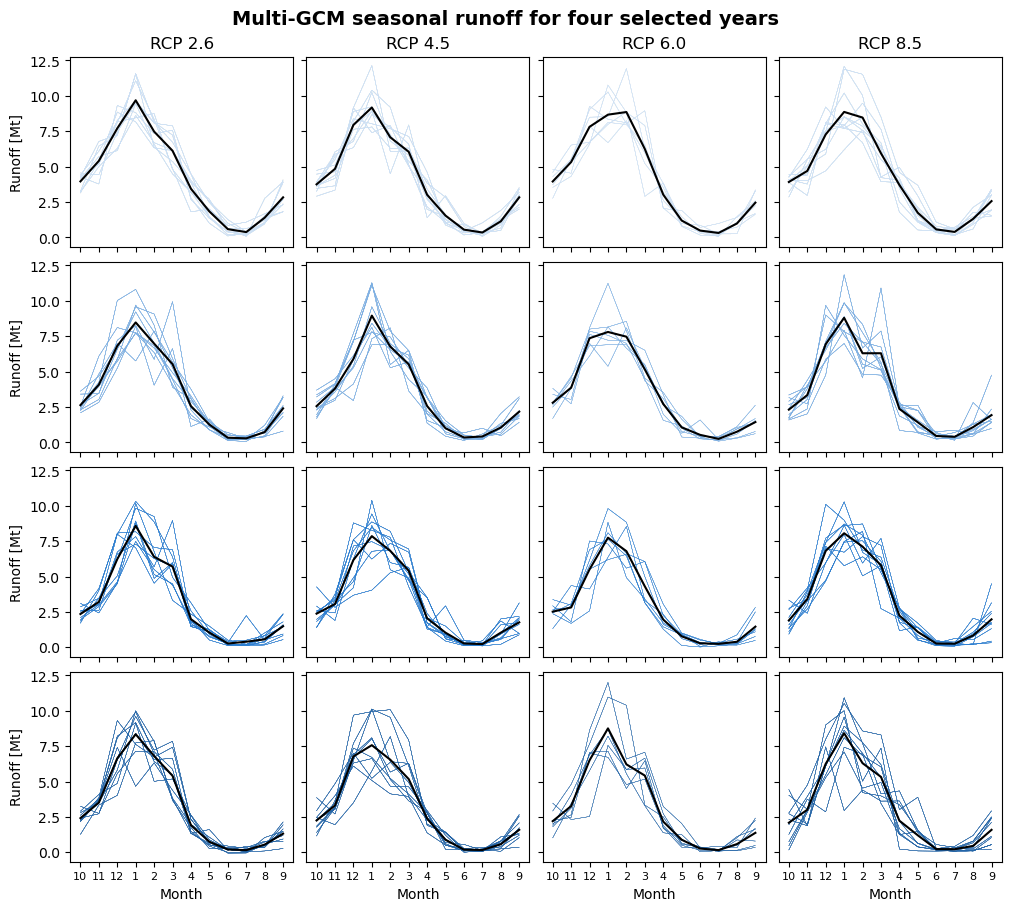

In [519]:
# Same as above but with different colors!
time = [0, 20, 40, 80]

from matplotlib import cm
#color_ts = ('#c2f2f2', '#81cfdb', '#4c858f', '#23393d')
#New colors 5/4/23
color_ts = ('#cce0f4', '#7bafe3', '#2b7ed1', '#2365a8')

fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12), (ax13, ax14, ax15, ax16)) = plt.subplots(4, 4, figsize=(10, 9), sharex=True, sharey=True, constrained_layout = True)

# Make first row of RCPs for time t=0
t = time[0]
for k in season_unroll26.keys():
    color_idx = 0
    season_t = season_sliced(key_dict['rcp26'], dict_roll26, t)
    xvals = np.asarray(season_t.index)+1
    ax1.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.8)
ax1.plot(xvals, season_t['mean'], color='k', linewidth=1.5)

for k in season_unroll45.keys():
    color_idx = 0
    season_t = season_sliced(key_dict['rcp45'], dict_roll45, t)
    xvals = np.asarray(season_t.index)+1
    ax2.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.8)
ax2.plot(xvals, season_t['mean'], color='k', linewidth=1.5)

for k in season_unroll60.keys():
    color_idx = 0
    season_t = season_sliced(key_dict['rcp60'], dict_roll60, t)
    xvals = np.asarray(season_t.index)+1
    ax3.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.8)
ax3.plot(xvals, season_t['mean'], color='k', linewidth=1.5)

for k in season_unroll85.keys():
    color_idx = 0
    season_t = season_sliced(key_dict['rcp85'], dict_roll85, t)
    xvals = np.asarray(season_t.index)+1
    ax4.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.8)
ax4.plot(xvals, season_t['mean'], color='k', linewidth=1.5)


# Make second row of RCPs for time t=20
t = time[1]
for k in season_unroll26.keys():
    color_idx = 1
    season_t = season_sliced(key_dict['rcp26'], dict_roll26, t)
    xvals = np.asarray(season_t.index)+1
    ax5.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.7)
ax5.plot(xvals, season_t['mean'], color='k', linewidth=1.5)

for k in season_unroll45.keys():
    color_idx = 1
    season_t = season_sliced(key_dict['rcp45'], dict_roll45, t)
    xvals = np.asarray(season_t.index)+1
    ax6.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.7)
ax6.plot(xvals, season_t['mean'], color='k', linewidth=1.5)

for k in season_unroll60.keys():
    color_idx = 1
    season_t = season_sliced(key_dict['rcp60'], dict_roll60, t)
    xvals = np.asarray(season_t.index)+1
    ax7.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.7)
ax7.plot(xvals, season_t['mean'], color='k', linewidth=1.5)

for k in season_unroll85.keys():
    color_idx = 1
    season_t = season_sliced(key_dict['rcp85'], dict_roll85, t)
    xvals = np.asarray(season_t.index)+1
    ax8.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.7)
ax8.plot(xvals, season_t['mean'], color='k', linewidth=1.5)


# Make third row of RCPs for time t=40
t = time[2]
for k in season_unroll26.keys():
    color_idx = 2
    season_t = season_sliced(key_dict['rcp26'], dict_roll26, t)
    xvals = np.asarray(season_t.index)+1
    ax9.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.7)
ax9.plot(xvals, season_t['mean'], color='k', linewidth=1.5)

for k in season_unroll45.keys():
    color_idx = 2
    season_t = season_sliced(key_dict['rcp45'], dict_roll45, t)
    xvals = np.asarray(season_t.index)+1
    ax10.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.7)
ax10.plot(xvals, season_t['mean'], color='k', linewidth=1.5)

for k in season_unroll60.keys():
    color_idx = 2
    season_t = season_sliced(key_dict['rcp60'], dict_roll60, t)
    xvals = np.asarray(season_t.index)+1
    ax11.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.7)
ax11.plot(xvals, season_t['mean'], color='k', linewidth=1.5)

for k in season_unroll85.keys():
    color_idx = 2
    season_t = season_sliced(key_dict['rcp85'], dict_roll85, t)
    xvals = np.asarray(season_t.index)+1
    ax12.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.7)
ax12.plot(xvals, season_t['mean'], color='k', linewidth=1.5)


# Make fourth row of RCPs for time t=80
t = time[3]
for k in season_unroll26.keys():
    color_idx = 3
    season_t = season_sliced(key_dict['rcp26'], dict_roll26, t)
    xvals = np.asarray(season_t.index)+1
    ax13.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.7)
ax13.plot(xvals, season_t['mean'], color='k', linewidth=1.5)

for k in season_unroll45.keys():
    color_idx = 3
    season_t = season_sliced(key_dict['rcp45'], dict_roll45, t)
    xvals = np.asarray(season_t.index)+1
    ax14.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.7)
ax14.plot(xvals, season_t['mean'], color='k', linewidth=1.5)

for k in season_unroll60.keys():
    color_idx = 3
    season_t = season_sliced(key_dict['rcp60'], dict_roll60, t)
    xvals = np.asarray(season_t.index)+1
    ax15.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.7)
ax15.plot(xvals, season_t['mean'], color='k', linewidth=1.5)

for k in season_unroll85.keys():
    color_idx = 3
    season_t = season_sliced(key_dict['rcp85'], dict_roll85, t)
    xvals = np.asarray(season_t.index)+1
    ax16.plot(xvals, season_t, linewidth=0.15, color=color_ts[color_idx], alpha=0.7)
ax16.plot(xvals, season_t['mean'], color='k', linewidth=1.5)
    
ax1.set(xticks = season_roll['month_2d'].values,
       xticklabels = season_roll2['month_2d'].values,
       title = 'RCP 2.6');
ax2.set(xticks = season_roll['month_2d'].values,
       xticklabels = season_roll2['month_2d'].values,
       title = 'RCP 4.5');
ax3.set(xticks = season_roll['month_2d'].values,
       xticklabels = season_roll2['month_2d'].values,
       title = 'RCP 6.0');
ax4.set(xticks = season_roll['month_2d'].values,
       xticklabels = season_roll2['month_2d'].values,
       title = 'RCP 8.5');

ax1.set(ylabel = 'Runoff [Mt]')
ax5.set(ylabel = 'Runoff [Mt]')
ax9.set(ylabel = 'Runoff [Mt]')
ax13.set(ylabel = 'Runoff [Mt]',
        xlabel = 'Month')
ax14.set(xlabel = 'Month')
ax15.set(xlabel = 'Month')
ax16.set(xlabel = 'Month')

ax13.tick_params(axis='x', which='major', labelsize=8)
ax14.tick_params(axis='x', which='major', labelsize=8)
ax15.tick_params(axis='x', which='major', labelsize=8)
ax16.tick_params(axis='x', which='major', labelsize=8)

plt.suptitle('Multi-GCM seasonal runoff for four selected years', fontweight = 'bold', fontsize = 14);

#plt.savefig('Figures/Seasonal/Slice/all_rcps_all_GCMs_16mega_may4', bbox_inches='tight')

# Visualize decades!

In [207]:
s_keys_dict = {}
s_keys_dict['rcp26'] = rtype_calc_s26.keys()
s_keys_dict['rcp45'] = rtype_calc_s45.keys()
s_keys_dict['rcp60'] = rtype_calc_s60.keys()
s_keys_dict['rcp85'] = rtype_calc_s85.keys()

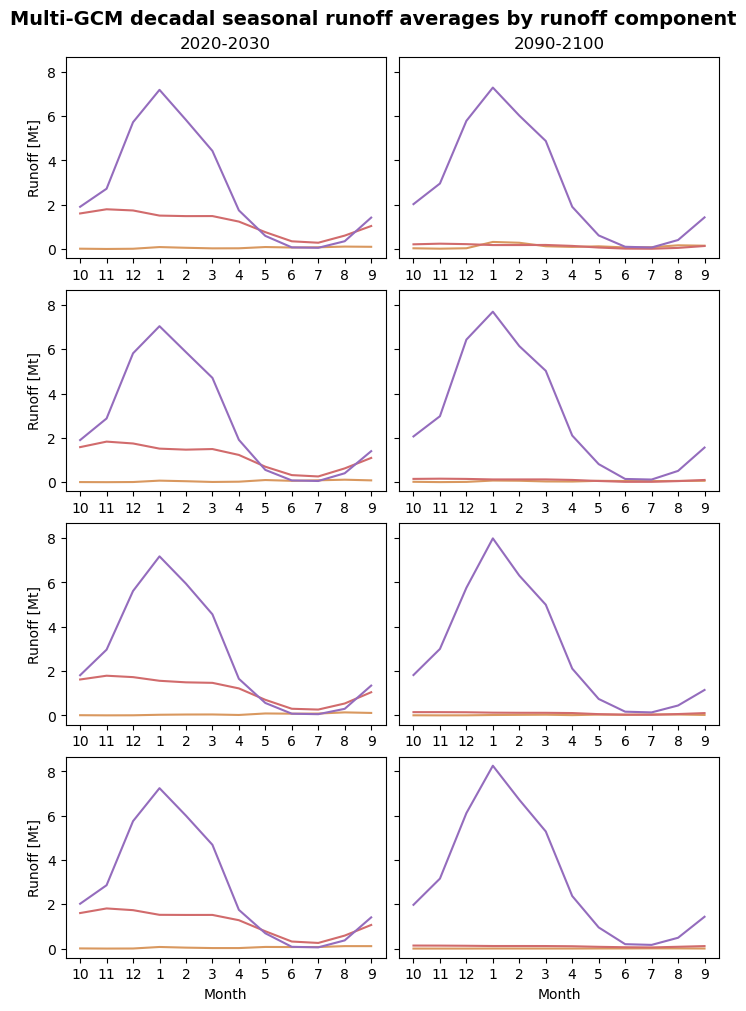

In [57]:
# Make this into a visual
runoff_variables = ['melt_off_glacier_m', 'melt_on_glacier_m']
sum_vars = ['liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m']

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(7, 10), sharey=True, constrained_layout = True);

color_pr = '#946cbd'
color_m = ('#d9985f', '#d16b6c')

s_keys = rtype_calc_s26.keys()
ct=0
for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s26, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e26, r)
    xvals = index2
    ax1.plot(xvals, runoff_s['mean'], label=r, color=color_m[ct])
    ax2.plot(xvals, runoff_e['mean'], label=r, color=color_m[ct])
    ct=ct+1
runoff_s = rtype_calc_monthly_2vars(s_keys, rtype_calc_s26, sum_vars[0], sum_vars[1])
runoff_e = rtype_calc_monthly_2vars(s_keys, rtype_calc_e26, sum_vars[0], sum_vars[1])
xvals = index2
ax1.plot(xvals, runoff_s['mean'], label=r, color=color_pr)
ax2.plot(xvals, runoff_e['mean'], label=r, color=color_pr)

s_keys = rtype_calc_s45.keys()
ct=0
for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s45, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e45, r)
    xvals = index2
    ax3.plot(xvals, runoff_s['mean'], label=r, color=color_m[ct])
    ax4.plot(xvals, runoff_e['mean'], label=r, color=color_m[ct])
    ct=ct+1
runoff_s = rtype_calc_monthly_2vars(s_keys, rtype_calc_s45, sum_vars[0], sum_vars[1])
runoff_e = rtype_calc_monthly_2vars(s_keys, rtype_calc_e45, sum_vars[0], sum_vars[1])
xvals = index2
ax3.plot(xvals, runoff_s['mean'], label=r, color=color_pr)
ax4.plot(xvals, runoff_e['mean'], label=r, color=color_pr)

s_keys = rtype_calc_s60.keys()
ct=0
for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s60, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e60, r)
    xvals = index2
    ax5.plot(xvals, runoff_s['mean'], label=r, color=color_m[ct])
    ax6.plot(xvals, runoff_e['mean'], label=r, color=color_m[ct])
    ct=ct+1
runoff_s = rtype_calc_monthly_2vars(s_keys, rtype_calc_s60, sum_vars[0], sum_vars[1])
runoff_e = rtype_calc_monthly_2vars(s_keys, rtype_calc_e60, sum_vars[0], sum_vars[1])
xvals = index2
ax5.plot(xvals, runoff_s['mean'], label=r, color=color_pr)
ax6.plot(xvals, runoff_e['mean'], label=r, color=color_pr)
    
s_keys = rtype_calc_s85.keys()
ct=0
for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s85, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e85, r)
    xvals = index2
    ax7.plot(xvals, runoff_s['mean'], label=r, color=color_m[ct])
    ax8.plot(xvals, runoff_e['mean'], label=r, color=color_m[ct])
    ct=ct+1
runoff_s = rtype_calc_monthly_2vars(s_keys, rtype_calc_s85, sum_vars[0], sum_vars[1])
runoff_e = rtype_calc_monthly_2vars(s_keys, rtype_calc_e85, sum_vars[0], sum_vars[1])
xvals = index2
ax7.plot(xvals, runoff_s['mean'], label=r, color=color_pr)
ax8.plot(xvals, runoff_e['mean'], label=r, color=color_pr)

ax1.set(ylabel='Runoff [Mt]', title='2020-2030')
ax2.set(title='2090-2100')
ax3.set(ylabel='Runoff [Mt]')
ax5.set(ylabel='Runoff [Mt]')
ax7.set(ylabel='Runoff [Mt]', xlabel = 'Month')
ax8.set(xlabel = 'Month')
# THIS WORKS
for ax in (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8):
    ax.set(xticks = season_roll['month_2d'].values,
           xticklabels = season_roll2['month_2d'].values, #here, we want calendar year values
          );

plt.suptitle('Multi-GCM decadal seasonal runoff averages by runoff component', fontweight = 'bold', fontsize = 14);

#plt.savefig('Figures/Seasonal/Decade_av/4x2_seasonsall_rcps.png', bbox_inches='tight')

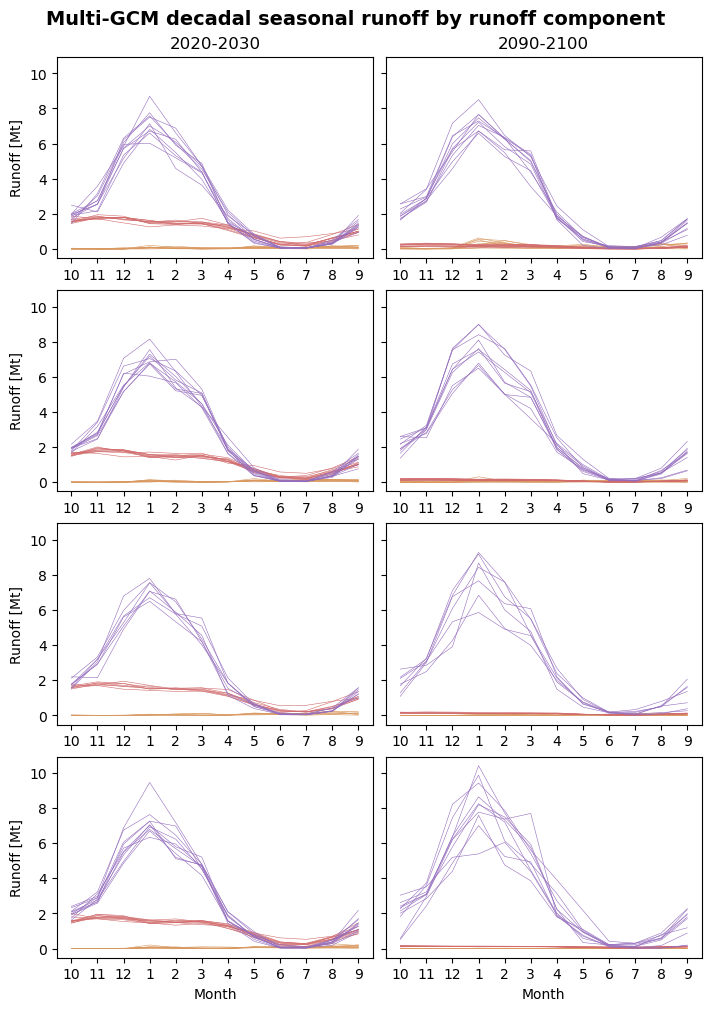

In [58]:
# Visualize seasonal runoff by component for each GCM
runoff_variables = ['melt_off_glacier_m', 'melt_on_glacier_m']
sum_vars = ['liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m']

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(7, 10), sharey=True, constrained_layout = True);

color_pr = '#946cbd'
color_m = ('#d9985f', '#d16b6c')

# RCP2.6
s_keys = rtype_calc_s26.keys()
ct=0
for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s26, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e26, r)
    xvals = index2
    for g in s_keys:
        ax1.plot(xvals, runoff_s[g], color=color_m[ct], linewidth=0.4)
        ax2.plot(xvals, runoff_e[g], color=color_m[ct], linewidth=0.4)
#    ax1.plot(xvals, runoff_s['mean'], label=r, color='#75362b')
#    ax2.plot(xvals, runoff_e['mean'], label=r, color='#915700')
    ct=ct+1
runoff_s = rtype_calc_monthly_2vars(s_keys, rtype_calc_s26, sum_vars[0], sum_vars[1])
runoff_e = rtype_calc_monthly_2vars(s_keys, rtype_calc_e26, sum_vars[0], sum_vars[1])
for g in s_keys:
    ax1.plot(xvals, runoff_s[g], color=color_pr, linewidth=0.4)
    ax2.plot(xvals, runoff_e[g], color=color_pr, linewidth=0.4)
#ax1.plot(xvals, runoff_s['mean'], label=r, color='#753f8f')
#ax2.plot(xvals, runoff_e['mean'], label=r, color='#753f8f')


# RCP4.5
s_keys = rtype_calc_s45.keys()
ct=0
for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s45, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e45, r)
    xvals = index2
    for g in s_keys:
        ax3.plot(xvals, runoff_s[g], color=color_m[ct], linewidth=0.4)
        ax4.plot(xvals, runoff_e[g], color=color_m[ct], linewidth=0.4)
#    ax1.plot(xvals, runoff_s['mean'], label=r, color='#75362b')
#    ax2.plot(xvals, runoff_e['mean'], label=r, color='#915700')
    ct=ct+1
runoff_s = rtype_calc_monthly_2vars(s_keys, rtype_calc_s45, sum_vars[0], sum_vars[1])
runoff_e = rtype_calc_monthly_2vars(s_keys, rtype_calc_e45, sum_vars[0], sum_vars[1])
for g in s_keys:
    ax3.plot(xvals, runoff_s[g], color=color_pr, linewidth=0.4)
    ax4.plot(xvals, runoff_e[g], color=color_pr, linewidth=0.4)
#ax1.plot(xvals, runoff_s['mean'], label=r, color='#753f8f')
#ax2.plot(xvals, runoff_e['mean'], label=r, color='#753f8f')


# RCP6.0
s_keys = rtype_calc_s60.keys()
ct=0
for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s60, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e60, r)
    xvals = index2
    for g in s_keys:
        ax5.plot(xvals, runoff_s[g], color=color_m[ct], linewidth=0.4)
        ax6.plot(xvals, runoff_e[g], color=color_m[ct], linewidth=0.4)
#    ax1.plot(xvals, runoff_s['mean'], label=r, color='#75362b')
#    ax2.plot(xvals, runoff_e['mean'], label=r, color='#915700')
    ct=ct+1
runoff_s = rtype_calc_monthly_2vars(s_keys, rtype_calc_s60, sum_vars[0], sum_vars[1])
runoff_e = rtype_calc_monthly_2vars(s_keys, rtype_calc_e60, sum_vars[0], sum_vars[1])
for g in s_keys:
    ax5.plot(xvals, runoff_s[g], color=color_pr, linewidth=0.4)
    ax6.plot(xvals, runoff_e[g], color=color_pr, linewidth=0.4)
#ax1.plot(xvals, runoff_s['mean'], label=r, color='#753f8f')
#ax2.plot(xvals, runoff_e['mean'], label=r, color='#753f8f')


# RCP8.5
s_keys = rtype_calc_s85.keys()
ct=0
for r in runoff_variables:
    runoff_s = rtype_calc_monthly(s_keys, rtype_calc_s85, r)
    runoff_e = rtype_calc_monthly(s_keys, rtype_calc_e85, r)
    xvals = index2
    for g in s_keys:
        ax7.plot(xvals, runoff_s[g], color=color_m[ct], linewidth=0.4)
        ax8.plot(xvals, runoff_e[g], color=color_m[ct], linewidth=0.4)
#    ax1.plot(xvals, runoff_s['mean'], label=r, color='#75362b')
#    ax2.plot(xvals, runoff_e['mean'], label=r, color='#915700')
    ct=ct+1
runoff_s = rtype_calc_monthly_2vars(s_keys, rtype_calc_s85, sum_vars[0], sum_vars[1])
runoff_e = rtype_calc_monthly_2vars(s_keys, rtype_calc_e85, sum_vars[0], sum_vars[1])
for g in s_keys:
    ax7.plot(xvals, runoff_s[g], color=color_pr, linewidth=0.4)
    ax8.plot(xvals, runoff_e[g], color=color_pr, linewidth=0.4)
#ax1.plot(xvals, runoff_s['mean'], label=r, color='#753f8f')
#ax2.plot(xvals, runoff_e['mean'], label=r, color='#753f8f')
    

ax1.set(ylabel='Runoff [Mt]', title='2020-2030')
ax2.set(title='2090-2100')
ax3.set(ylabel='Runoff [Mt]')
ax5.set(ylabel='Runoff [Mt]')
ax7.set(ylabel='Runoff [Mt]', xlabel = 'Month')
ax8.set(xlabel = 'Month')
# THIS WORKS
for ax in (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8):
    ax.set(xticks = season_roll['month_2d'].values,
           xticklabels = season_roll2['month_2d'].values, #here, we want calendar year values
          );

plt.suptitle('Multi-GCM decadal seasonal runoff by runoff component', fontweight = 'bold', fontsize = 14);

#plt.savefig('Figures/Seasonal/Decade_av/4x2_seasonsall_rcps_allgcms.png', bbox_inches='tight')

### Plot of relative contribution on decade scale

In [521]:
# Set up the dictionaries with values to use in the summing function
s_keys_dict = {}
s_keys_dict['rcp26'] = rtype_calc_s26.keys()
s_keys_dict['rcp45'] = rtype_calc_s45.keys()
s_keys_dict['rcp60'] = rtype_calc_s60.keys()
s_keys_dict['rcp85'] = rtype_calc_s85.keys()

rtype_calc_dict_s = {}
rtype_calc_dict_s['rcp26'] = rtype_calc_s26
rtype_calc_dict_s['rcp45'] = rtype_calc_s45
rtype_calc_dict_s['rcp60'] = rtype_calc_s60
rtype_calc_dict_s['rcp85'] = rtype_calc_s85

rtype_calc_dict_e = {}
rtype_calc_dict_e['rcp26'] = rtype_calc_e26
rtype_calc_dict_e['rcp45'] = rtype_calc_e45
rtype_calc_dict_e['rcp60'] = rtype_calc_e60
rtype_calc_dict_e['rcp85'] = rtype_calc_e85

In [522]:
rcp = ('rcp26', 'rcp45', 'rcp60', 'rcp85')

all_rcp_dict_s = {}

for r in rcp:
    melt_on = rtype_calc_monthly(s_keys_dict[r], rtype_calc_dict_s[r], 'melt_on_glacier_m')
    melt_off = rtype_calc_monthly(s_keys_dict[r], rtype_calc_dict_s[r], 'melt_off_glacier_m')
    liq = rtype_calc_monthly_2vars(s_keys_dict[r], rtype_calc_dict_s[r], 'liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m')
    summed = melt_on + melt_off + liq
    m_on_name = 'm-on-{}'.format(r)
    m_off_name = 'm-off-{}'.format(r)
    liq_name = 'liq-{}'.format(r)
    sum_name = 'sum-{}'.format(r)
    all_rcp_dict_s[m_on_name] = melt_on
    all_rcp_dict_s[m_off_name] = melt_off
    all_rcp_dict_s[liq_name] = liq
    all_rcp_dict_s[sum_name] = summed

all_rcp_dict_e = {}

for r in rcp:
    melt_on = rtype_calc_monthly(s_keys_dict[r], rtype_calc_dict_e[r], 'melt_on_glacier_m')
    melt_off = rtype_calc_monthly(s_keys_dict[r], rtype_calc_dict_e[r], 'melt_off_glacier_m')
    liq = rtype_calc_monthly_2vars(s_keys_dict[r], rtype_calc_dict_e[r], 'liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m')
    summed = melt_on + melt_off + liq
    m_on_name = 'm-on-{}'.format(r)
    m_off_name = 'm-off-{}'.format(r)
    liq_name = 'liq-{}'.format(r)
    sum_name = 'sum-{}'.format(r)
    all_rcp_dict_e[m_on_name] = melt_on
    all_rcp_dict_e[m_off_name] = melt_off
    all_rcp_dict_e[liq_name] = liq
    all_rcp_dict_e[sum_name] = summed

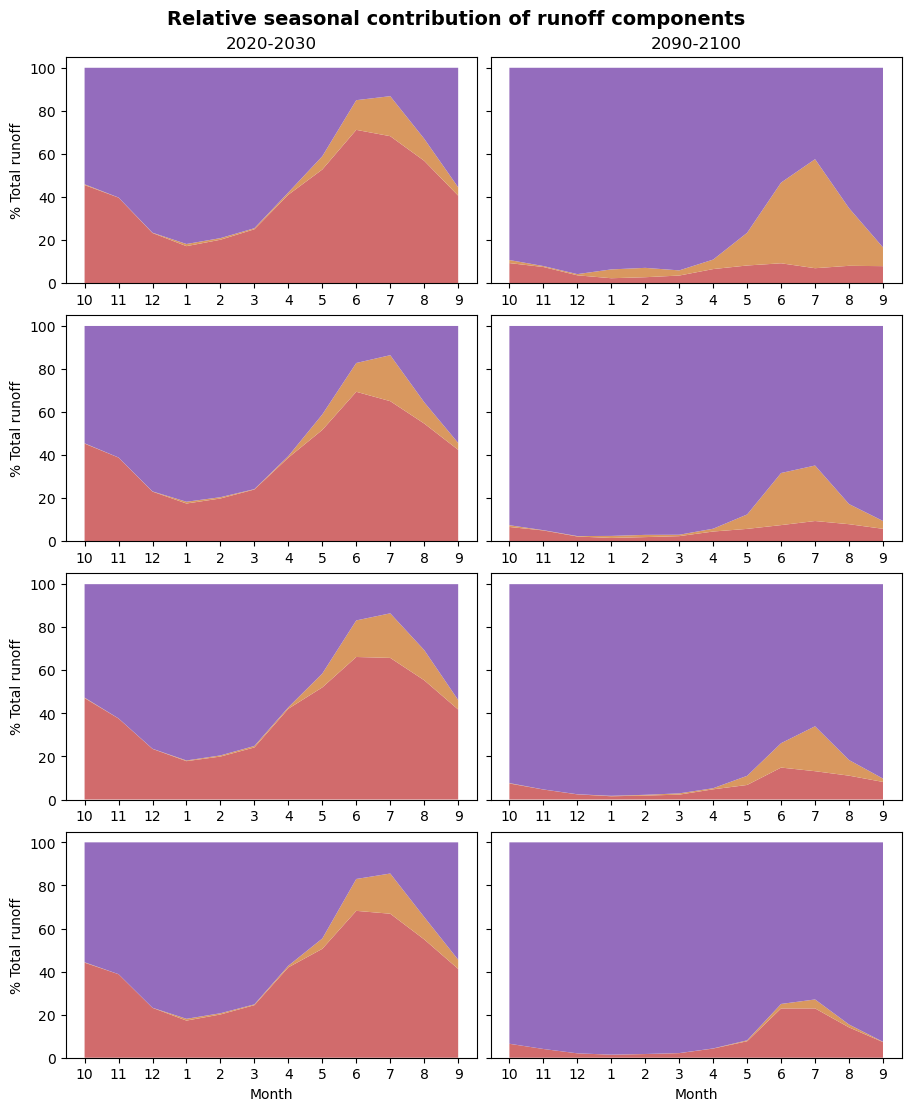

In [526]:
# Graph of relative importance of runoff for each part of the seasonal cycle (decade 1 and last)

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(9, 11), sharey=True, constrained_layout = True);

color_pr = '#946cbd'
color_m = ('#d9985f', '#d16b6c')

xvals = index2

# RCP 2.6
rcp_key = 'rcp26'
ax1.stackplot(xvals, all_rcp_dict_s['m-on-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_s['sum-{}'.format(rcp_key)]['mean'], 
              all_rcp_dict_s['m-off-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_s['sum-{}'.format(rcp_key)]['mean'],
              all_rcp_dict_s['liq-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_s['sum-{}'.format(rcp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

ax2.stackplot(xvals, all_rcp_dict_e['m-on-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_e['sum-{}'.format(rcp_key)]['mean'], 
              all_rcp_dict_e['m-off-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_e['sum-{}'.format(rcp_key)]['mean'],
              all_rcp_dict_e['liq-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_e['sum-{}'.format(rcp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

# RCP4.5
rcp_key = 'rcp45'
ax3.stackplot(xvals, all_rcp_dict_s['m-on-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_s['sum-{}'.format(rcp_key)]['mean'], 
              all_rcp_dict_s['m-off-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_s['sum-{}'.format(rcp_key)]['mean'],
              all_rcp_dict_s['liq-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_s['sum-{}'.format(rcp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

ax4.stackplot(xvals, all_rcp_dict_e['m-on-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_e['sum-{}'.format(rcp_key)]['mean'], 
              all_rcp_dict_e['m-off-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_e['sum-{}'.format(rcp_key)]['mean'],
              all_rcp_dict_e['liq-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_e['sum-{}'.format(rcp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

# RCP6.0
rcp_key = 'rcp60'
ax5.stackplot(xvals, all_rcp_dict_s['m-on-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_s['sum-{}'.format(rcp_key)]['mean'], 
              all_rcp_dict_s['m-off-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_s['sum-{}'.format(rcp_key)]['mean'],
              all_rcp_dict_s['liq-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_s['sum-{}'.format(rcp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

ax6.stackplot(xvals, all_rcp_dict_e['m-on-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_e['sum-{}'.format(rcp_key)]['mean'], 
              all_rcp_dict_e['m-off-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_e['sum-{}'.format(rcp_key)]['mean'],
              all_rcp_dict_e['liq-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_e['sum-{}'.format(rcp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

# RCP85
rcp_key = 'rcp85'
ax7.stackplot(xvals, all_rcp_dict_s['m-on-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_s['sum-{}'.format(rcp_key)]['mean'], 
              all_rcp_dict_s['m-off-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_s['sum-{}'.format(rcp_key)]['mean'],
              all_rcp_dict_s['liq-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_s['sum-{}'.format(rcp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

ax8.stackplot(xvals, all_rcp_dict_e['m-on-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_e['sum-{}'.format(rcp_key)]['mean'], 
              all_rcp_dict_e['m-off-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_e['sum-{}'.format(rcp_key)]['mean'],
              all_rcp_dict_e['liq-{}'.format(rcp_key)]['mean']*100/all_rcp_dict_e['sum-{}'.format(rcp_key)]['mean'],
              labels=['Melt on glacier', 'Melt off glacier', 'Liquid precipitation'],
              colors=['#d16b6c', '#d9985f', '#946cbd']);

#ax1.legend(bbox_to_anchor=(0.44, 0.95));

plt.suptitle('Relative seasonal contribution of runoff components', fontweight = 'bold', fontsize = 14);

ax1.set(ylabel='% Total runoff', title='2020-2030')
ax2.set(title='2090-2100')
ax3.set(ylabel='% Total runoff')
ax5.set(ylabel='% Total runoff')
ax7.set(ylabel='% Total runoff', xlabel = 'Month')
ax8.set(xlabel = 'Month')
# THIS WORKS
for ax in (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8):
    ax.set(xticks = season_roll['month_2d'].values,
           xticklabels = season_roll2['month_2d'].values #here, we want calendar year values
          );

#plt.savefig('Figures/Seasonal/Decade_av/4x2_relative_importance_newMay4.png', bbox_inches='tight')

## <b> Calculations for decadal seasonality

Month of peak runoff

In [65]:
def dec_av(dataframe):
    key = dataframe.keys()
    array = []
    for k in key:
        select_gcm = dataframe['{}'.format(k)]
        month_index = np.argmax(select_gcm)
        array.append(month_index)
    mean = (sum(array)/len(key))
    return mean

<b> RCP26

In [66]:
s_keys = rtype_calc_s26.keys()

In [67]:
runoff_variables = ['melt_off_glacier_m', 'melt_on_glacier_m']
sum_vars = ['liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m']

run26_s_liq = rtype_calc_monthly_2vars(s_keys, rtype_calc_s26, sum_vars[0], sum_vars[1])
run26_s_moff = rtype_calc_monthly(s_keys, rtype_calc_s26, 'melt_off_glacier_m')
run26_s_mon = rtype_calc_monthly(s_keys, rtype_calc_s26, 'melt_on_glacier_m')

drop26l = run26_s_liq.drop('mean', axis = 'columns')
drop26mf = run26_s_moff.drop('mean', axis = 'columns')
drop26mn = run26_s_mon.drop('mean', axis = 'columns')

In [68]:
e_keys = rtype_calc_e26.keys()

In [69]:
run26_e_liq = rtype_calc_monthly_2vars(e_keys, rtype_calc_e26, sum_vars[0], sum_vars[1])
run26_e_moff = rtype_calc_monthly(e_keys, rtype_calc_e26, 'melt_off_glacier_m')
run26_e_mon = rtype_calc_monthly(e_keys, rtype_calc_e26, 'melt_on_glacier_m')

edrop26l = run26_e_liq.drop('mean', axis = 'columns')
edrop26mf = run26_e_moff.drop('mean', axis = 'columns')
edrop26mn = run26_e_mon.drop('mean', axis = 'columns')

In [70]:
s26avl = dec_av(drop26l)
s26avmf = dec_av(drop26mf)
s26avmn = dec_av(drop26mn)

e26avl = dec_av(edrop26l)
e26avmf = dec_av(edrop26mf)
e26avmn = dec_av(edrop26mn)

In [71]:
drop26l

,CCSM4-rcp26,CNRM-CM5-rcp26,CSIRO-Mk3-6-0-rcp26,CanESM2-rcp26,GFDL-CM3-rcp26,GFDL-ESM2G-rcp26,GISS-E2-R-rcp26,IPSL-CM5A-LR-rcp26,MPI-ESM-LR-rcp26,NorESM1-M-rcp26
month_2d,,,,,,,,,,
7,1.962327,1.918523,2.501172,1.988808,2.014195,1.652334,1.759831,1.442543,1.961695,1.857472
8,2.534269,2.176344,2.108420,3.577475,2.754349,3.023998,2.571484,3.155439,2.550260,2.758867
9,6.219085,5.353207,4.884516,5.843862,5.957715,6.054147,5.158419,6.309732,5.745475,5.711748
10,7.507810,6.604148,6.816301,8.695686,6.023012,7.759650,7.138505,7.577426,7.009264,6.718379
11,6.880740,5.307020,5.488625,6.607468,5.187064,5.904418,4.583408,5.979450,6.087975,6.244512
12,4.726097,4.381789,3.965914,4.744792,4.337230,4.869819,3.633098,4.544547,4.690969,4.380882
1,1.954971,1.456185,1.522216,2.218073,1.733014,1.491187,1.884129,2.097900,1.638380,1.444603
2,0.567882,0.327234,0.726401,0.844064,0.560237,0.450538,0.814466,0.730443,0.528508,0.370872
3,0.054103,0.057805,0.118379,0.108081,0.049615,0.080124,0.047422,0.069026,0.096298,0.053562


Months correspond to: <br>
7, index 0, is actually 10 <br>
8, index 1, is actually 11<br>
9, index 2, is actually 0/12<br>
10, index 3, is actually 1 <br>
11, index 4, is actually 2<br>
12, index 5, is actually 3<br>
1, index 6, is actually 4<br>
2, index 7, is actually 5<br>
3, index 8, is actually 6<br>
4, index 9, is actually 7<br>
5, index 10, is actually 8<br>
6, index 11, is actually 9


In [72]:
# These are indices of where they're located, but don't necessarily correspond to the month!
print(s26avl)
print(s26avmf)
print(s26avmn)

print(e26avl)
print(e26avmf)
print(e26avmn)

3.0
7.8
1.4
3.0
4.2
0.9


<b> RCP 45

In [73]:
s_keys = rtype_calc_s45.keys()

In [77]:
runoff_variables = ['melt_off_glacier_m', 'melt_on_glacier_m']
sum_vars = ['liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m']

run45_s_liq = rtype_calc_monthly_2vars(s_keys, rtype_calc_s45, sum_vars[0], sum_vars[1])
run45_s_moff = rtype_calc_monthly(s_keys, rtype_calc_s45, 'melt_off_glacier_m')
run45_s_mon = rtype_calc_monthly(s_keys, rtype_calc_s45, 'melt_on_glacier_m')

drop45l = run45_s_liq.drop('mean', axis = 'columns')
drop45mf = run45_s_moff.drop('mean', axis = 'columns')
drop45mn = run45_s_mon.drop('mean', axis = 'columns')

In [78]:
e_keys = rtype_calc_e45.keys()

In [79]:
run45_e_liq = rtype_calc_monthly_2vars(e_keys, rtype_calc_e45, sum_vars[0], sum_vars[1])
run45_e_moff = rtype_calc_monthly(e_keys, rtype_calc_e45, 'melt_off_glacier_m')
run45_e_mon = rtype_calc_monthly(e_keys, rtype_calc_e45, 'melt_on_glacier_m')

edrop45l = run45_e_liq.drop('mean', axis = 'columns')
edrop45mf = run45_e_moff.drop('mean', axis = 'columns')
edrop45mn = run45_e_mon.drop('mean', axis = 'columns')

In [80]:
s45avl = dec_av(drop45l)
s45avmf = dec_av(drop45mf)
s45avmn = dec_av(drop45mn)

e45avl = dec_av(edrop45l)
e45avmf = dec_av(edrop45mf)
e45avmn = dec_av(edrop45mn)

Months correspond to: <br>
7, index 0, is actually 10 <br>
8, index 1, is actually 11<br>
9, index 2, is actually 0/12<br>
10, index 3, is actually 1 <br>
11, index 4, is actually 2<br>
12, index 5, is actually 3<br>
1, index 6, is actually 4<br>
2, index 7, is actually 5<br>
3, index 8, is actually 6<br>
4, index 9, is actually 7<br>
5, index 10, is actually 8<br>
6, index 11, is actually 9


In [81]:
# These are indices of where they're located, but don't necessarily correspond to the month!
print(s45avl)
print(s45avmf)
print(s45avmn)

print(e45avl)
print(e45avmf)
print(e45avmn)

3.0
8.0
1.3
3.0
6.8
1.0


<b> RCP 60

In [83]:
s_keys = rtype_calc_s60.keys()

In [84]:
runoff_variables = ['melt_off_glacier_m', 'melt_on_glacier_m']
sum_vars = ['liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m']

run60_s_liq = rtype_calc_monthly_2vars(s_keys, rtype_calc_s60, sum_vars[0], sum_vars[1])
run60_s_moff = rtype_calc_monthly(s_keys, rtype_calc_s60, 'melt_off_glacier_m')
run60_s_mon = rtype_calc_monthly(s_keys, rtype_calc_s60, 'melt_on_glacier_m')

drop60l = run60_s_liq.drop('mean', axis = 'columns')
drop60mf = run60_s_moff.drop('mean', axis = 'columns')
drop60mn = run60_s_mon.drop('mean', axis = 'columns')

In [85]:
e_keys = rtype_calc_e60.keys()

In [86]:
run60_e_liq = rtype_calc_monthly_2vars(e_keys, rtype_calc_e60, sum_vars[0], sum_vars[1])
run60_e_moff = rtype_calc_monthly(e_keys, rtype_calc_e60, 'melt_off_glacier_m')
run60_e_mon = rtype_calc_monthly(e_keys, rtype_calc_e60, 'melt_on_glacier_m')

edrop60l = run60_e_liq.drop('mean', axis = 'columns')
edrop60mf = run60_e_moff.drop('mean', axis = 'columns')
edrop60mn = run60_e_mon.drop('mean', axis = 'columns')

In [87]:
s60avl = dec_av(drop60l)
s60avmf = dec_av(drop60mf)
s60avmn = dec_av(drop60mn)

e60avl = dec_av(edrop60l)
e60avmf = dec_av(edrop60mf)
e60avmn = dec_av(edrop60mn)

Months correspond to: <br>
7, index 0, is actually 10 <br>
8, index 1, is actually 11<br>
9, index 2, is actually 0/12<br>
10, index 3, is actually 1 <br>
11, index 4, is actually 2<br>
12, index 5, is actually 3<br>
1, index 6, is actually 4<br>
2, index 7, is actually 5<br>
3, index 8, is actually 6<br>
4, index 9, is actually 7<br>
5, index 10, is actually 8<br>
6, index 11, is actually 9


In [88]:
# These are indices of where they're located, but don't necessarily correspond to the month!
print(s60avl)
print(s60avmf)
print(s60avmn)

print(e60avl)
print(e60avmf)
print(e60avmn)

3.0
9.428571428571429
1.0
3.0
7.0
1.0


<b> RCP 85

In [89]:
s_keys = rtype_calc_s85.keys()

In [90]:
runoff_variables = ['melt_off_glacier_m', 'melt_on_glacier_m']
sum_vars = ['liq_prcp_off_glacier_m', 'liq_prcp_on_glacier_m']

run85_s_liq = rtype_calc_monthly_2vars(s_keys, rtype_calc_s85, sum_vars[0], sum_vars[1])
run85_s_moff = rtype_calc_monthly(s_keys, rtype_calc_s85, 'melt_off_glacier_m')
run85_s_mon = rtype_calc_monthly(s_keys, rtype_calc_s85, 'melt_on_glacier_m')

drop85l = run85_s_liq.drop('mean', axis = 'columns')
drop85mf = run85_s_moff.drop('mean', axis = 'columns')
drop85mn = run85_s_mon.drop('mean', axis = 'columns')

In [91]:
e_keys = rtype_calc_e85.keys()

In [92]:
run85_e_liq = rtype_calc_monthly_2vars(e_keys, rtype_calc_e85, sum_vars[0], sum_vars[1])
run85_e_moff = rtype_calc_monthly(e_keys, rtype_calc_e85, 'melt_off_glacier_m')
run85_e_mon = rtype_calc_monthly(e_keys, rtype_calc_e85, 'melt_on_glacier_m')

edrop85l = run85_e_liq.drop('mean', axis = 'columns')
edrop85mf = run85_e_moff.drop('mean', axis = 'columns')
edrop85mn = run85_e_mon.drop('mean', axis = 'columns')

In [93]:
s85avl = dec_av(drop85l)
s85avmf = dec_av(drop85mf)
s85avmn = dec_av(drop85mn)

e85avl = dec_av(edrop85l)
e85avmf = dec_av(edrop85mf)
e85avmn = dec_av(edrop85mn)

Months correspond to: <br>
7, index 0, is actually 10 <br>
8, index 1, is actually 11<br>
9, index 2, is actually 0/12<br>
10, index 3, is actually 1 <br>
11, index 4, is actually 2<br>
12, index 5, is actually 3<br>
1, index 6, is actually 4<br>
2, index 7, is actually 5<br>
3, index 8, is actually 6<br>
4, index 9, is actually 7<br>
5, index 10, is actually 8<br>
6, index 11, is actually 9


In [94]:
# These are indices of where they're located, but don't necessarily correspond to the month!
print(s85avl)
print(s85avmf)
print(s85avmn)

print(e85avl)
print(e85avmf)
print(e85avmn)

3.0
9.3
0.9
3.1
7.9
1.1


#### <b> Calculating spread!

In [64]:
def dec_range(dataframe, mean_idx):
    mean_rd = int(mean_idx.round())
    df_peak = dataframe.iloc[mean_rd]
    min_val = min(df_peak)
    max_val = max(df_peak)
    range_val = max_val - min_val
    return range_val

<b> 26

In [501]:
print('liquid start', dec_range(drop26l, s26avl))
print('liquid end', dec_range(edrop26l, e26avl))

print('moff start', dec_range(drop26mf, s26avmf))
print('moff end', dec_range(edrop26mf, e26avmf))

print('mon start', dec_range(drop26mn, s26avmn))
print('mon end', dec_range(edrop26mn, e26avmn))

liquid start 2.6726741790771484
liquid end 1.9161362648010254
moff start 0.08519141748547554
moff end 0.4409790709614754
mon start 0.27300572395324707
mon end 0.20521561801433563


<b> 45

In [502]:
print('liquid start', dec_range(drop45l, s45avl))
print('liquid end', dec_range(edrop45l, e45avl))

print('moff start', dec_range(drop45mf, s45avmf))
print('moff end', dec_range(edrop45mf, e45avmf))

print('mon start', dec_range(drop45mn, s45avmn))
print('mon end', dec_range(edrop45mn, e45avmn))

liquid start 2.112424373626709
liquid end 2.506801128387451
moff start 0.05738924816250801
moff end 0.10903322976082563
mon start 0.36858034133911133
mon end 0.12181904911994934


<b> 60

In [503]:
print('liquid start', dec_range(drop60l, s60avl))
print('liquid end', dec_range(edrop60l, e60avl))

print('moff start', dec_range(drop60mf, s60avmf))
print('moff end', dec_range(edrop60mf, e60avmf))

print('mon start', dec_range(drop60mn, s60avmn))
print('mon end', dec_range(edrop60mn, e60avmn))

liquid start 1.304551124572754
liquid end 3.4174671173095703
moff start 0.10746368113905191
moff end 0.05244760122150183
mon start 0.21102476119995117
mon end 0.08567702025175095


<b> 85

In [504]:
print('liquid start', dec_range(drop85l, s85avl))
print('liquid end', dec_range(edrop85l, e85avl))

print('moff start', dec_range(drop85mf, s85avmf))
print('moff end', dec_range(edrop85mf, e85avmf))

print('mon start', dec_range(drop85mn, s85avmn))
print('mon end', dec_range(edrop85mn, e85avmn))

liquid start 3.1178722381591797
liquid end 5.021553039550781
moff start 0.11697759851813316
moff end 0.015334105381043628
mon start 0.2638406753540039
mon end 0.03463486582040787


#### <b> RCP spread

In [ ]:
sRCPavCOMP
run85_s_liq

In [99]:
s26meanl = run26_s_liq['mean'].iloc[int(s26avl.round())+2]
print('26 liquid', s26meanl)

s45meanl = run45_s_liq['mean'].iloc[int(s45avl.round())+2]
print('45 liquid', s45meanl)

s60meanl = run60_s_liq['mean'].iloc[int(s60avl.round())+2]
print('60 liquid', s60meanl)

s85meanl = run85_s_liq['mean'].iloc[int(s85avl.round())+2]
print('85 liquid', s85meanl)

print('range', s45meanl - s26meanl)

26 liquid 4.427514
45 liquid 4.709151
60 liquid 4.562776
85 liquid 4.685043
range 0.28163671


In [101]:
s26meanmf = run26_s_moff['mean'].iloc[int(s26avmf.round())+2]
print('26 liquid', s26meanmf)

s45meanmf = run45_s_moff['mean'].iloc[int(s45avmf.round())+2]
print('45 liquid', s45meanmf)

s60meanmf = run60_s_moff['mean'].iloc[int(s60avmf.round())+2]
print('60 liquid', s60meanmf)

s85meanmf = run85_s_moff['mean'].iloc[int(s85avmf.round())+2]
print('85 liquid', s85meanmf)

print('range', s85meanmf - s26meanmf)

26 liquid 0.10892241
45 liquid 0.112694
60 liquid 0.11049684
85 liquid 0.11043725
range 0.0015148446


In [102]:
s26meanmn = run26_s_mon['mean'].iloc[int(s26avmn.round())+2]
print('26 liquid', s26meanmn)

s45meanmn = run45_s_mon['mean'].iloc[int(s45avmn.round())+2]
print('45 liquid', s45meanmn)

s60meanmn = run60_s_mon['mean'].iloc[int(s60avmn.round())+2]
print('60 liquid', s60meanmn)

s85meanmn = run85_s_mon['mean'].iloc[int(s85avmn.round())+2]
print('85 liquid', s85meanmn)

print('range', s85meanmn - s26meanmn)

26 liquid 1.5081661
45 liquid 1.5152165
60 liquid 1.5620766
85 liquid 1.5239294
range 0.015763283
